# Predicting StarCraft II Win Probability - Notebook 1
By: [**Jared Lloyd**](https://github.com/jared-a-lloyd/sc2-modeling)

__[Brainstation](https://brainstation.io/)__ Capstone Project

---

## Introduction

StarCraft II (SC2) is a Real-Time Strategy game (RTS) which has been a popular eSport since its release in 2010. The game has progressed through a number of iterations, the most recent release (2015) being "Legacy of the Void" (LOTV).

### How does the game work?
The game is played by two or more two players but the primary focus of the competitive amateur and professional scene is one-on-one (1v1) games. It is a largely successful game, with around 500,000 players per season at its peak in 2019. There are several professional players that are approaching USD1 million in winnings, with total winnings at around USD37 million (__[source](https://liquipedia.net/starcraft2/Winnings)__).

<img src="img/avg-player-population.png" width="1000">

<center>
<b>Average Player Population per Season</b> (<i>Source: <a href="https://www.rankedftw.com/stats/population/1v1/#v=2&r=-2&sy=c&sx=a">rankedftw.com</a></i>)
</center>

#### What is Matchmaking Rating (MMR)?
A player will queue up for a "ladder game" (a game against another human competitor), and match-making is performed using MMR which is a measure of relative player skill, similar to __[ELO](https://en.wikipedia.org/wiki/Elo_rating_system)__ in chess. A win or loss in a ladder game is used to update the MMR of both players, with the adjustment being proportional to the initial difference in MMR between the two players, i.e. beating a player with much higher MMR will result in a high adjustment. 

The MMR range is between 0 and around 7,500. Although there is no technical upper limit for MMR, once a player reaches such high levels, the relative MMR gain per game becomes very small because the MMR difference between other players becomes so large. A player with an MMR around 7,500 will gain only 1 or 2 MMR for a win, but lose as much as 50 or more MMR for a loss, making it difficult to increase their MMR over time.

#### Game setup
Each player chooses one of three races: <a style="color:goldenrod"><b>Protoss</b></a>, <a style="color:firebrick"><b>Terran</b></a>, or <a style="color:darkviolet"><b>Zerg</b></a> - allowing for a total of 6 possible match-ups. The game begins with a player having 12 worker units and a main base. The basic strategy for the game is outlined by:
* Use workers to mine one of the two resources on the map: Mineral or vespene gas.
* Use workers to construct buildings to create military units, research upgrades, collect more resources, and defend their base.
* Expand bases to new locations on the map. There are typically 5 to 7 bases available for each player to expand to.
* Use military units to attack enemy units, while maintaining economic balance.

#### Winning the game
A game is won when a player has destroyed all enemy buildings. However, games typically end earlier than this as one player concedes when it becomes clear that they can no longer win.

## Goal of the project

The goal of this Jupyter Notebook series is to model the win-probability as the game progresses. Previous work has been done on this topic __[\[1\]](http://ceur-ws.org/Vol-1394/paper_3.pdf)[\[2\]](https://www.semanticscholar.org/paper/A-machine-learning-approach-to-predict-the-winner-S%C3%A1nchez-Ruiz-Granados-Miranda/e8a52f985cfc6eee2b05fbd91c613397cc922b44)__, focusing on using primarily Support Vector Machines (SVM) to predict the winner of a game, based on the game's current state. These approaches were able to predict the winner of the game with an accuracy of 60% to 80% depending on how late into the game the winner was predicted.

This project is attempting to use Recurrent Neural Networks (RNN), to impute the game state without requiring it to be explicitly calculated on some specific features (such as number of buildings, or composition of armies). RNN was chosen for the ability to remember game sequences of events, much like a human player would.

### Motivation

#### 1) Broadcasting
Professional games are widely broadcast, with the 2019 WCS Global Finals having an average live viewership of 36,430, peak viewership of 80,030 and prize pool of $500,000 (__[source](https://escharts.com/tournaments/sc2/wcs-global-finals-2019)__).

An overlay which occasionally updates viewers with the probability of one player winning would be an interesting feature to add, highlighting "big moments" in the game where the win-probability swings from one players favor to the other.

#### 2) Player analysis
It is common practice for players and professionals to re-watch their own games in order to understand how they performed, and what improvements could be made. Players even hire professional coaches to help them improve their skills for as much as __[USD85/hour](https://www.pigstarcraft.com/coaching/)__.

This tool would allow for additional insights into which moments were most significant in affecting the outcome of the game, as well as helping players identify where they have conceded too early, perhaps saving them some of that coaching money.

#### 3) AI training
SC2 is already a popular field of study for AI, with Google's __[AlphaStar](https://deepmind.com/blog/article/alphastar-mastering-real-time-strategy-game-starcraft-ii)__ having been trained to the point where it could even defeat professional players. Predicting the probability of victory for a given game state could provide an additional reward metric for training AIs.

In addition to the above, this methodology could also be applied to new games such as Age of Empires, or even popular turn-based strategy games such as Civilization VI.

## Data Sources
Data are sourced from `SC2REPLAY` files which are autogenerated by the game client every time a game is played. SC2 is a fully deterministic game, meaning that the replay files simply contain a list of each and every action taken in the game. To find out what happens at any given moment in the game, one has to simulate every action up until that point in time.

A python package named __[sc2reader](https://github.com/ggtracker/sc2reader)__ is used to read the replay files, converting each replay into an object with attributes that contain both metadata and game events. This package is used in a number of publicly available replay analysis tools, as well as tools to analyze the actions most often taken by players in-game. It is for this reason that the data extracted from replays is trusted as true and accurate.

A replay file contains data at a frame by frame level. There are 16 frames in an in-game second, and 1.4 in-game seconds in a real-time second, i.e. there are 22.4 frames per real-time second.

### Datasets
Two datasets are collected:
* __[Blizzard](https://github.com/Blizzard/s2client-proto#downloads)__: A collection of &pm;1.2 million replays which were specifically provided by the game developers, Blizzard, for the purpose of training AI agents to play the game. These replay files are anonymized and contain only the actions taken by the players, and not the game state. In this study we use the Blizzard dataset to train a metadata model that attempts to predict the outcome of the game based only on the information available before the game starts. 
* __[SpawningTool](https://lotv.spawningtool.com/replays/)__: 48,479 replay files downloaded from a collection of user-uploaded replay files. These replay files are not anonymized and contain the game state at every moment in the game. In this study we use the SpawningTool dataset to train a neural network that predicts the probability of victory for a player as the game progresses. The dataset is also used as the test data for the Metadata Model.

### Data Flow
The planned flow of the project is outlined in the figure below.

<img src="img/overall_process_flow.png" width="1000">

<center>
<b>Diagram outlining the planned flow of data through the project</b></a></i>)
</center>

The flow can be described as follows:
* Replay files will be processed using `sc2reader` using twice. Once at level 2 for both the Blizzard and SpawningTool replay collections, to extract the Metadata. And once at level 4 for the SpawningTool replay collection to extract the game Event Data.
* `csv` files will be used to store the Metadata, while the Event Data will be stored as zip files, ready for conversion to a 3D tensor.
* Metadata model training will be done using Blizzard Metadata and then re-tested using the SpawningTool Metadata.
* The SpawningTool Metadata will also be used to track the Event Data. Providing a quick way to access attributes of each replay.
* Finally, an RNN model will be trained on the SpawningTool Event Data, and the accuracy compared against the best that was achieved in the Metadata model.

## Methodology
* **Notebook 1 (this notebook): Data Collection** - Process replay files to extract metadata and game events.
    * Collect data from `SC2REPLAY` files:    
        * *Metadata*: The information about the game, such as the map; player names, races, and MMR; and game outcome, length and region. Metadata for each dataset are stored in a single `csv` file per dataset. Data are collected using `sc2reader` using the `load_level=2` setting to increase speed of replay parsing. Each load level increases the amount of detail extracted at the cost of additional processing time and memory.
        * *Event data*: The actions taken by the players in the game, such as the units created, resource collection rates and spending, etc. Game events for each game are to be stored in a `zip` file, named after the filehash of the original replay file. This allows easy referencing to a particular game events file from the metadata file.
    * Clean Event Data
        * Create a dataframe from each `zip` file.
        * Remove all irrelevant actions.
        * Divide game events into actions taken by each player.
        * Store a final dataframe that consists of a single row per frame of the game.
    * The goal of this Notebook can be summarized as: 
    <center><i><b><a style="color:darkviolet">How can we extract meaningful data from a StarCraft 2 game replay file?</a></b></i></center>

* **Notebook 2: Metadata Analysis and Modeling** 
    * Visually explore the metadata.
    * Understand the distribution of player levels, races, regions, etc.
    * Model the outcome of the game based on metadata alone. Train the model using the Blizzard dataset and test it using the SpawningTool dataset.
    * The goal of this Notebook can be summarized as: 
    <center><i><b><a style="color:darkviolet">Are there inherent biases at game which would favor one player over the other from the outset?</a></b></i></center>

* **Notebook 3: Event Data Analysis and Modeling**
    * Visually explore the event data
    * Understand the types of actions that are taken, and create any new features that could be used to improve modeling.
    * Construct and train a Recurrent Neural Network (RNN) to predict the probability of victory for a player as the game progresses.
    * Compare RNN to the Metadata Model to understand if the RNN is an improvement of game understanding.
    * Conclusions and further work to be done.
    * The goal of this Notebook can be summarized as: *How well can an independent observer predict the match outcome as the game progresses?
    <center><i><b><a style="color:darkviolet">How well can an independent observer predict the match outcome as the game progresses?</a></b></i></center>

For Notebook 1 and 2 an environment named `sc2` is created in Conda which contains the following core packages:
* `pandas`
* `numpy`
* `scipy`
* `matplotlib`
* `seaborn`
* `scikit-learn`
* `sc2reader`
* `multiprocessing`

For Notebook 3 a new environment named `tflow2` is used:
* `tensorflow`
* `numpy`
* `pandas`
* `matplotlib`

Should the `yml` for the `tflow2` environment not work, the following commands were used to create the basic environment (several packages were subsequently installed):

```bash
conda create --name tflow python=3.9 pip jupyter matplotlib numpy scikit-learn pandas
conda activate tflow
python -m pip install --upgrade pip --user
python -m pip install tensorflow
conda install cuda -c nvidia
conda install -c conda-forge cudnn
```

`yml` files are included in this repository to set up each environment.

## Table of Contents
1. [Metadata Collection](#section-1)
    1. [Processing Replay Files](#section-1-1)
    2. [Metadata Cleaning](#section-1-2)
2. [Event Data Collection](#section-2)
    1. [Processing Replay Files](#section-2-1)
    2. [Cleaning Event Data](#section-2-2)
    3. [Bulk Processing Event Data](#section-2-3)
3. [Conclusion](#section-3)

---

#### Package imports and settings:
Notes:
* To deal with the size of the dataframes in this Notebook, the `pandas` max_rows and max_columns settings are set to 200. If editing any code please use `.head()` or some other limit when displaying dataframes.


In [1]:
# initial imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sc2reader
import re
import random
import datetime
import json
from scripts.classes import ReplayInfo
import time
import math
import multiprocessing as mp

# import warnings
import warnings

# import tqdm for progress bars
from tqdm import tqdm

# import partial for specifying functions for apply and multiprocessing
from functools import partial

# import IPython display
from IPython.display import display
# required for %%writefile code to update after changes
%load_ext autoreload 

#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style do not need to set
# each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 12 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 13
# set figure size
mpl.rcParams['figure.figsize'] = (18, 8)

#### Constants
# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }

#### Pandas options
# these are set to allow better exploration of the large dataframes in this 
# notebook
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# Data Collection

## Section 1: Metdata Collection <a name="section-1"></a>

This process is broken down into two phases:
1. **Metadata collection** - Extract the metadata from both SpawningTool and Blizzard datasets.
2. **Data cleaning** - Explore the data to determine how much complete information is available. The data should be relatively clean, as duplicates are already removed during replay parsing.

### 1.1 - Processing Replay Files <a name="section-1-1"></a>

To process the metadata, the following steps will be followed:
1. A python script `process_replays.py` is written using the IPython magic `%%writefile` to the scripts folder. The separate script enables the use of multiprocessing to significantly improve the speed of execution. Note: `%autoreload` is used to make sure that if a script is run a second time after changing a `%%writefile` script, the script will be re-imported. Otherwise, the kernel requires a restart to reflect the changes.
2. A replay file is loaded using `load_replay` from the `s2reader` package. Load level 2 is selected as it contains the relevant player and metadata.
3. The replay is parsed using the `ReplayInfo` class (found in scripts/classes/replay_info.py, and also written using `%%writefile`).
4. The parsed replay is added to a list of replays which is then converted to a pandas dataframe.
5. The dataframe is then written to a csv file. Separate csv files are created for SpawningTool and Blizzard replays in the data folder (`spawningtool_replays.csv` and `blizzard_replays.csv` respectively). 

The metadata collected are:
* `Map hash` - this is used in reference to the map name, as different regions have different translations for the same map.
* `Player races`
* `Player MMR` (if available)
* `Player highest league`
* `Game length`
* `Game outcome`
* `Game type` (to ensure that the game is 1v1 instead of a 4 player game etc.)
* `Game speed` (an additional check that the game format is correct)
* `Game FPS` (an additional check that the game format is correct)
* `Game timestamp`
* `Region` of the game server that the replay was played on
* `Filehash` - this is used to ensure that replays are not duplicated, and as an identifier for event data `pkl` files.
* `Is_ladder` - If the game is a ladder game (checking that the game format is correct).

#### Script to extract metadata from replay files
A script is written to allow the use of multiprocessing to improve the speed of execution. The settings in `replay_settings.json` allow the user to specify the number of cores that will be used during execution. Setting `n_jobs` to -1 will use all available threads minus one to prevent locking up when all threads are occupied.

This function is written as a self-contained script instead of a callable function to allow easy use of the script should others want to perform similar analysis on SC2 replays.

In [2]:
%%writefile scripts/process_replays.py
"""
This file is used to process replays and extract the data
It is used as a separate script to allow for parallel processing, and for portability.
The ReplayInfo class is required to be located at scripts/classes/ReplayInfo.py for processing

Settings are specified in a scripts/replay_settings.json file. The following settings are available:
        - replay_dir: The directory where replays are located, searches through any child folders as well
        - sample_size: The number of replays to attempt to extract. Any that fail will reduce this amount
        - n_jobs: Number of multiprocessing threads to use. -1 sets the maximum available, less one. Any positive int
                    will be used as is
        - random_seed: The random seed to be used if sampling is selected.
"""
import json
import os
import multiprocessing as mp
import random
import sc2reader
from scripts.classes import ReplayInfo
import pandas as pd
import time
from tqdm import tqdm

def process_replay(filename):
    """
    process_replay
    ___________________________________________________________________________
    Processes a replay file and returns a ReplayInfo object if the replay is valid according to the filters. Else returns None.

    Args:
        filename (string): Absolute path to the replay file.
        filters (dict): A dictionary of filters to apply to the replay. Dictionary keys are the attributes of ReplayInfo, and values are those that should be excluded.
    
    Returns:
        [type]: [description]
    """
    # load replay
    # use try, except to not derail the entire process if a single file fails
    try:
        replay = sc2reader.load_replay(
            filename,
            load_level=2 # level 2 is all that is required for metadata
            )
    except:
        return None

    try:
        replay_object = ReplayInfo(replay)
    except: # catch exceptions created by ReplayInfo
        return None

    return replay_object

if __name__ == "__main__":

    # suppress warnings when running within Notebooks
    __spec__ = None 
    
    # start timer
    timer = time.time()

    # load settings
    with open("scripts/replay_settings.json", "r") as file:
        settings = json.load(file)

    # get replay directory from settings
    replay_dir = settings["replay_dir"]

    # get sample size from settings
    sample_size = settings["sample_size"]

    # get n_jobs from settings
    n_jobs = settings["n_jobs"]

    # get output_file from settings
    output_file = settings["output_file"]
    if output_file == "":
        output_file = 'data/replays.csv'

    # get random seed from settings
    # check if random_seed key exists
    if "random_seed" in settings:
        random_seed = settings["random_seed"]
    else:
        random_seed = None

    replays_list = []
    # loop through replay directory and get list of .SC2Replay files
    for dirpath, dirnames, filenames in os.walk(replay_dir):
        for filename in filenames:
            if filename.endswith('.SC2Replay'):
                filepath = os.path.join(dirpath, filename)
                replays_list.append(filepath)

    # if the user has chosen to take a sample
    if sample_size != -1:
        # take a random sample of replays
        random.seed(random_seed)
        replays_list = random.sample(replays_list, sample_size)

    # set the number of processes to use
    if n_jobs == -1:
        cpu_total = mp.cpu_count() - 1 # cpu_count() returns total number of cores
    else:
        cpu_total = n_jobs

    print(f'Processing {len(replays_list)} replays')

    # set up and run multiprocessing pool
    # imap is used to allow tqdm to calculate a progress bar
    with mp.Pool(processes=cpu_total) as pool:
        replay_collection = list(tqdm(pool.imap(
                process_replay,
                replays_list,
                chunksize=10
            ),
            total=len(replays_list),
            desc='Processing replays',
            unit='replays'
        ))

    # remove all None from replay_collection (failed replays)
    replay_collection = [x for x in replay_collection if x is not None]

    # convert replay collection to dataframe
    replay_df = pd.DataFrame({
        'filename':[x.filename for x in replay_collection],
        'map':[x.map_hash for x in replay_collection],
        'player1_race':[x.player_races[0] for x in replay_collection],
        'player2_race':[x.player_races[1] for x in replay_collection],
        'player1_mmr':[x.player_mmrs[0] for x in replay_collection],
        'player2_mmr':[x.player_mmrs[1] for x in replay_collection],
        'game_length':[x.game_length for x in replay_collection],
        'game_type':[x.game_type for x in replay_collection],
        'game_speed':[x.game_speed for x in replay_collection],
        'game_winner':[x.game_winner for x in replay_collection],
        'timestamp':[x.timestamp for x in replay_collection],
        'fps':[x.fps for x in replay_collection],
        'is_ladder':[x.is_ladder for x in replay_collection],
        'region':[x.region for x in replay_collection],
        'player1_highest_league':[
            x.highest_league[0] for x in replay_collection
        ],
        'player2_highest_league':[
            x.highest_league[1] for x in replay_collection
        ],
        'filehash':[x.filehash for x in replay_collection]
    })

    # remove rows with duplicate filehashes
    replay_df = replay_df.drop_duplicates(subset='filehash')

    # write replay_collection to csv with no index
    replay_df.to_csv(output_file, index=False)

    # found x valid replays
    print(f'Found {replay_df.shape[0]} unique valid replays')
    # print time elapsed as HH:MM:SS
    print(f'Time elapsed: {time.strftime("%H:%M:%S", time.gmtime(time.time() - timer))}')


Overwriting scripts/process_replays.py


#### Class definition for ReplayInfo
This class is used to parse the replay files and extract the metadata to more easily convert it into a pandas dataframe.

In [3]:
%%writefile scripts/classes/ReplayInfo.py
"""
Classes used in the analysis of replays.

Current list:
    - ReplayInfo - Extract metadata from replay files. (e.g. map, player names, etc.)
"""
import re

class ReplayInfo:

    def __init__(self, replay):
        # self.__Replay = replay
        self.map_hash = replay.map_hash
        self.player_races = self._get_player_races(replay)
        self.filename = replay.filename
        self.player_mmrs = self._get_player_mmrs(replay)
        self.game_length = self._get_game_length(replay)
        self.game_winner = self._get_winner(replay)
        self.timestamp = replay.unix_timestamp
        self.game_type = replay.type
        self.game_speed = replay.speed
        self.fps = replay.game_fps
        self.is_ladder = replay.is_ladder
        self.region = replay.region
        self.highest_league = self._get_player_highest_league(replay)
        self.filehash = replay.filehash


    def _get_game_length(self, replay):

        # this converts to minutes.seconds
        length_string = str(replay.game_length)

        # use regex to extract all numbers from length_string
        split_string = length_string.split('.')
        # if there is only one value, assume it is minutes
        minutes = split_string[0]
        if len(split_string) > 1:
            seconds = split_string[1]

        # convert to int in seconds
        return int(minutes)*60 + int(seconds)


    def _get_winner(self, replay):

        winner_string = str(replay.winner)
        if 'Player 1' in winner_string:
            return 1
        elif 'Player 2' in winner_string:
            return 2
        else:
            return 0


    def _get_player_highest_league(self, replay):
        
        # the location of highest league is set using these strings for readability
        str_a = 'replay.initData'
        str_b = 'user_initial_data'
        str_c = 'highest_league'

        # check that replay.initData exists in key
        if str_a not in replay.raw_data.keys():
            # some replays (like the Blizzard set) keep their data here
            str_a = 'replay.initData.backup' 
        
        return (
            replay.raw_data[str_a][str_b][0][str_c],
            replay.raw_data[str_a][str_b][1][str_c]
            )


    def _get_player_mmrs(self, replay):

        # the location of highest league is set using these strings for readability
        str_a = 'replay.initData'
        str_b = 'user_initial_data'
        str_c = 'scaled_rating'

        # check that replay.initData exists in key
        if str_a not in replay.raw_data.keys():
            # some replays (like the Blizzard set) keep their data here
            str_a = 'replay.initData.backup'

        return (
            replay.raw_data[str_a][str_b][0][str_c],
            replay.raw_data[str_a][str_b][1][str_c]
            )


    # get the player races
    def _get_player_races(self, replay):
        """
        _get_player_races
        Iterate through players in self.__Replay.players and extract player
        races as strings from the info

        Returns:
            tuple - Length 2 contain the races of both players
        """

        player_string = []

        for player in replay.players:
            # convert player to string
            player_string.append(str(player))


        return (
            self._get_race(player_string[0]),
            self._get_race(player_string[1])
            )


    def _get_race(self, player):
        """
        _get_race Extract race from string. String is assumed to be of the form:
        'Player x - Race'.

        Args:
            player (str): A string of form 'Player x - Race'

        Returns:
            str: Race of the player
        """

        RACE_LIST = [
            'Protoss',
            'Terran',
            'Zerg'
        ]

        # assert that player is a string
        assert isinstance(player, str), 'player should be a string'


        for race in RACE_LIST:

            race_string = '('+race+')'

            if race_string.lower() in player.lower():

                # assert that race_string is in player
                assert race_string in player, \
                    f'{player} does not adhere to to {race_string} formatting'
                # use replace to delete the player race
                player = player.replace(race_string, '')

                # create regex to find 'Player 1 - ' leaving only name
                reg_str = r'Player\s\d\s\-\s'

                # assert that reg_str is in player string
                assert re.search(reg_str, player), \
                    f'{player} does not adhere to to {reg_str} formatting'

                return race

Overwriting scripts/classes/ReplayInfo.py


Now that the process for extracting the metadata is defined, the script can be run using the `%%run` magic. For each of the two runs, only the `replay_settings.json` file found in the scripts folder needs to be modified.

#### Extract SpawningTool metadata
This script took approximately 1 minute to run on a 6 core machine.

In [4]:
# specify json settings in scripts/replay_settings.json
replay_settings = {
    "replay_dir": "data/SpawningTool",
    "sample_size": -1,
    "n_jobs": -1,
    "output_file": "data/spawningtool_replays.csv"
}

# write json settings to file
with open("scripts/replay_settings.json", "w") as file:
    json.dump(replay_settings, file, indent=4)

# run the script to extract metadata from replays
%run ./scripts/process_replays.py 

Processing 48479 replays


Processing replays: 100%|██████████| 48479/48479 [00:49<00:00, 974.52replays/s] 


Found 36812 unique valid replays
Time elapsed: 00:00:50


In [5]:
# inspect the dataframe
df = pd.read_csv('data/spawningtool_replays.csv')
display(df.head())
print('SpawningTool replays shape', df.shape)

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/SpawningTool\Other\page1\2-liberator-tank...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Protoss,-36400.0,NaN,402,1v1,Normal,1,1633598712,16.0,False,us,4,0,9384fda8c370ea7d130ac20244f7d0fda9a9b834004445...
1,data/SpawningTool\Other\page1\2-liberators-1-t...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Zerg,-36400.0,NaN,371,1v1,Normal,1,1633603684,16.0,False,us,4,0,f9864054498acf297aacf2be80896ba131716a341983de...
2,data/SpawningTool\Other\page1\2000-atmospheres...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,1633788999,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...
3,data/SpawningTool\Other\page1\2021-09-05-zserr...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,NaN,NaN,1803,1v1,Faster,1,1630608640,16.0,False,eu,7,6,99ba80721116d18f965c141581baa878abf02526f48bc6...
4,data/SpawningTool\Other\page1\2021-10-01-zvaev...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,1633138764,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...


SpawningTool replays shape (36812, 17)


#### Extract Blizzard metadata
This script took approximately 16 minutes to run on a 6 core machine.

In [6]:
# specify json settings in scripts/replay_settings.json
replay_settings = {
    "replay_dir": "data/Blizzard",
    "sample_size": -1,
    "n_jobs": -1,
    "output_file": "data/blizzard_replays.csv"
}

# write json settings to file
with open("scripts/replay_settings.json", "w") as file:
    json.dump(replay_settings, file, indent=4)

# run the script to extract metadata from replays
%run ./scripts/process_replays.py 

Processing 1225046 replays


Processing replays: 100%|██████████| 1225046/1225046 [15:18<00:00, 1334.12replays/s]


Found 1203339 unique valid replays
Time elapsed: 00:16:07


In [7]:
# inspect the dataframe
df = pd.read_csv('data/blizzard_replays.csv')
display(df.head())
print('Blizzard replays shape', df.shape)

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/Blizzard\set_1\0000e057beefc9b1e9da959ed9...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,1v1,Faster,2,1502208724,16.0,True,eu,6,6,9706f355243444e1666cd19a3a6cc1a315957e885f2ded...
1,data/Blizzard\set_1\0002b71a92623234bf67fac85e...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1v1,Faster,1,1502197141,16.0,True,eu,5,5,e60e9fcdde514415eb2466ceab3c7d23af2b4549d74e89...
2,data/Blizzard\set_1\0002c4f2d94ba7aaf2f71b9d8c...,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,1v1,Faster,2,1502280613,16.0,True,eu,5,0,82f4f6bf5d2c0af9b5a8f5c0c9606a0dc6819b09ae9a7a...
3,data/Blizzard\set_1\000309f32db5b1e65312208cca...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1v1,Faster,1,1502262699,16.0,True,cn,3,3,2cc2384ffd09b3f6a63aa4fd2223db082dad6917c0f3b6...
4,data/Blizzard\set_1\000484de77e46af60af75a20b8...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1v1,Faster,1,1502290022,16.0,True,us,5,5,537f1b82a364599638da021fabb2c9d975c94ca2f59eb7...


Blizzard replays shape (1203339, 17)


### 1.2 - Metadata cleaning <a name="section-1-2"></a>
Metadata will be used for modeling the outcome of the game. It is expected that the most important features will relate to player MMRs, and races. The completeness of these components will be checked.

This step will not make any changes to the data stored in the `csv` files, but will rather be used as a template to create a function that can be imported in Notebook 2 to clean the data as needed, before it is used in the modeling.

#### Correct filenames
The filenames in the `csv` are constructed with inconsistent forward- and backslashes. While these may still 
work correctly, it may be worth updating these filenames to use the correct forwardslash at this point for consistency and ease of usage.

In [8]:
def correct_slash_direction(df):
    """
    correct_slash_direction
    Inspect file paths in the filename column of the supplied dataframe and 
    correct the slash direction to standard forwardslash.

    Args:
        df (pandas.DataFrame): A pandas dataframe with a filename column

    Returns:
        pandas.DataFrame: A pandas dataframe with the corrected file paths
    """    

    # assert that df is a dataframe
    assert isinstance(df, pd.DataFrame), 'df should be a dataframe'

    # assert that filename column exists
    assert 'filename' in df.columns, 'df should have a filename column'

    # assert that filename column is a string
    assert isinstance(df['filename'][0], str), \
        'filename column should be a string'

    # correct \\ and \ to / in filename column
    # first check for \\ and then check for \
    df['filename'] = df['filename'].apply(lambda x: x.replace('\\\\', '/'))
    df['filename'] = df['filename'].apply(lambda x: x.replace('\\', '/'))

    return df

In [9]:
# correct SpawningTool dataframe and update the csv file
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')
spawningtool_df = correct_slash_direction(spawningtool_df)
spawningtool_df.to_csv('data/spawningtool_replays.csv', index=False)

# correct Blizzard dataframe and update the csv file
blizzard_df = pd.read_csv('data/blizzard_replays.csv')
blizzard_df = correct_slash_direction(blizzard_df)
blizzard_df.to_csv('data/blizzard_replays.csv', index=False)

#### Inspect the dataframes

In [10]:
print("The shape of the SpawningTool dataframe is", spawningtool_df.shape)
print("The shape of the Blizzard dataframe is    ", blizzard_df.shape)

The shape of the SpawningTool dataframe is (36812, 17)
The shape of the Blizzard dataframe is     (1203339, 17)


The inspections will be the same for both datasets. We have 36,812 records in the SpawningTool dataset, and 1,203,339 records in the Blizzard dataset, with both datasets containing a total of 17 features.

#### Identify amount of missing data

In [11]:
print("Fraction of missing values in SpawningTool dataframe:")
spawningtool_df.isna().sum()/spawningtool_df.shape[0]

Fraction of missing values in SpawningTool dataframe:


filename                  0.000000
map                       0.000000
player1_race              0.012333
player2_race              0.012333
player1_mmr               0.700532
player2_mmr               0.701782
game_length               0.000000
game_type                 0.000000
game_speed                0.000000
game_winner               0.000000
timestamp                 0.000000
fps                       0.000000
is_ladder                 0.000000
region                    0.000000
player1_highest_league    0.000000
player2_highest_league    0.000000
filehash                  0.000000
dtype: float64

In [12]:
print("Fraction of missing values in Blizzard dataframe:")
blizzard_df.isna().sum()/blizzard_df.shape[0]

Fraction of missing values in Blizzard dataframe:


filename                  0.000000
map                       0.000000
player1_race              0.053712
player2_race              0.053712
player1_mmr               0.000000
player2_mmr               0.000000
game_length               0.000000
game_type                 0.000000
game_speed                0.000000
game_winner               0.000000
timestamp                 0.000000
fps                       0.000000
is_ladder                 0.000000
region                    0.000000
player1_highest_league    0.000000
player2_highest_league    0.000000
filehash                  0.000000
dtype: float64

The SpawningTool dataset appears to be missing a large amount of MMR data, which would otherwise have been meaningful in Metadata modeling. However, the primary purpose of this dataset is to train the neural network, and for that only the event data is required.

As a secondary check, we will define a valid MMR range and check the amount of replays in both datasets that would be considered valid.
* Minimum MMR: 2,000 - This value is selected as below this MMR range a player would be in "Bronze" league, and likely very new to the game. Their actions may not be as relevant to predicting the outcome of the game, and may confuse the model.
* Maximum MMR: 8,000 - The maximum MMR is selected as 8,000 as this should include all games. The top players in all regions tend to have MMRs of 7,500 and below. 8,000 is chosen as a safety margin so as to allow any future data to be processed without needing to adjust the code.

We will perform a quick check on the MMR ranges to confirm the above assumptions are valid.

In [13]:
# get the max and min MMR for each region for SpawningTool
spawningtool_df.groupby('region')[
    ['player1_mmr', 'player2_mmr']
].agg(['max', 'min'])

player1_mmr          player2_mmr         
               max      min         max      min
region                                          
cn          5828.0 -36400.0      6141.0 -36400.0
eu          7372.0 -36400.0      7416.0 -36400.0
kr          6883.0 -36400.0      6830.0 -36400.0
sea            NaN      NaN         NaN      NaN
us          6591.0 -36400.0      6798.0 -36400.0
xx             NaN      NaN         NaN      NaN

In [14]:
# get the max and min MMR for each region for Blizzard
blizzard_df.groupby('region')[
    ['player1_mmr', 'player2_mmr']
].agg(['max', 'min'])


player1_mmr        player2_mmr       
               max    min         max    min
region                                      
cn            6299 -36400        6922 -36560
eu            6901 -36560        7271 -36926
kr            6984 -36560        7020 -36786
us            6874 -36560        6990 -36560

Both datasets appear to have minimum MMRs that are negative, indicating some error in the data. This will be cleaned by specifying the minimum MMR range. The maximum MMR range of 8,000 appears to be reasonable, as the highest in either dataset is 7,416.

In [15]:
# min and max values for MMR
min_mmr, max_mmr = 2000, 8000

# count the number of replays with both players MMRs between min and max

print("The number of valid MMR replays in SpawningTool is", 
    spawningtool_df[
        (spawningtool_df['player1_mmr'] >= min_mmr) &
        (spawningtool_df['player1_mmr'] <= max_mmr) &
        (spawningtool_df['player2_mmr'] >= min_mmr) &
        (spawningtool_df['player2_mmr'] <= max_mmr)
    ].shape[0]
)

print("The number of valid MMR replays in Blizzard is  ", 
    blizzard_df[
        (blizzard_df['player1_mmr'] >= min_mmr) &
        (blizzard_df['player1_mmr'] <= max_mmr) &
        (blizzard_df['player2_mmr'] >= min_mmr) &
        (blizzard_df['player2_mmr'] <= max_mmr)
    ].shape[0]    
)


The number of valid MMR replays in SpawningTool is 10162
The number of valid MMR replays in Blizzard is   1165910


Only &pm;10,000 replays from SpawningTool have valid MMRs (28% of 36,812), with 1,165,910 replays from Blizzard having valid MMRs (97% of 1,203,339). Because valid SpawningTool replays are such a small fraction of the Blizzard dataset (&pm;1%), we will use some Blizzard data to test as well as train the Metadata model, and then use the SpawningTool data as a supplementary test set.

#### Missing race data
It is worth noting that &pm;5% of the Blizzard data and &pm;1% of the SpawningTool data are missing race data for the players. This may be caused by player who play as "random". Random players are players who, instead of choosing a single race to play with, are randomly assigned a race at the beginning of each match. 

It may be possible to impute this missing data from event data for the SpawningTool data, for Blizzard data these replays will be dropped wherever race is used in modeling.

#### Converting timestamp to datetime
Timestamps in both `csv` files are stored as __[unix timestamps](https://en.wikipedia.org/wiki/Unix_time)__ (i.e. seconds since 1 January 1970). These can be easily converted to datetime using pandas.

In [16]:
# convert spawningtool_df['timestamp'] from unix to datetime
spawningtool_df['timestamp'] = pd.to_datetime(
    spawningtool_df['timestamp'], unit='s'
)

# convert blizzard_df['timestamp'] from unix to datetime
blizzard_df['timestamp'] = pd.to_datetime(
    blizzard_df['timestamp'], unit='s'
)

# update both csv files
spawningtool_df.to_csv('data/spawningtool_replays.csv', index=False)
blizzard_df.to_csv('data/blizzard_replays.csv', index=False)


#### Final checks on data quality
The pandas `describe()` method will be used to determine the value ranges for all numerical data in both datasets, to potentially identify abnormal values that may not be NaN (much like the negative MMR values).

Categorical columns (`race`, `game_type`, `map`  and `region`) will be inspected using the pandas `value_counts()` method.

In [17]:
print("<<<< SpawningTool Numerical Data >>>>")
# use describe to get the mean, std, min, max, and count of each column
# use an apply function to get the values in readable format
# as suggested here: 
# https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation
display(spawningtool_df.describe().T.apply(lambda x: x.map('{:,.2f}'.format)))

print("\u2500" * 80)
print("<<<< Blizzard Numerical Data >>>>")
display(blizzard_df.describe().T.apply(lambda x: x.map('{:,.2f}'.format)))

<<<< SpawningTool Numerical Data >>>>


,count,mean,std,min,25%,50%,75%,max
player1_mmr,"11,024.00","2,297.50","7,008.45","-36,400.00","2,716.00","3,184.00","4,066.00","7,372.00"
player2_mmr,"10,978.00","2,472.88","6,505.29","-36,400.00","2,738.00","3,182.00","4,078.75","7,416.00"
game_length,"36,812.00",708.34,358.35,0.00,472.00,653.00,880.00,"3,552.00"
game_winner,"36,812.00",1.38,0.59,0.00,1.00,1.00,2.00,2.00
fps,"36,812.00",16.00,0.00,16.00,16.00,16.00,16.00,16.00
player1_highest_league,"36,812.00",2.73,2.92,0.00,0.00,2.00,6.00,8.00
player2_highest_league,"36,812.00",2.88,2.93,0.00,0.00,2.00,6.00,8.00


────────────────────────────────────────────────────────────────────────────────
<<<< Blizzard Numerical Data >>>>


,count,mean,std,min,25%,50%,75%,max
player1_mmr,"1,203,339.00","3,647.70","1,692.64","-36,560.00","3,190.00","3,628.00","4,129.00","6,984.00"
player2_mmr,"1,203,339.00","2,670.85","6,456.05","-36,926.00","3,174.00","3,622.00","4,126.00","7,271.00"
game_length,"1,203,339.00",658.05,429.60,0.00,362.00,631.00,895.00,"3,596.00"
game_winner,"1,203,339.00",1.49,0.51,0.00,1.00,1.00,2.00,2.00
fps,"1,203,339.00",16.00,0.00,16.00,16.00,16.00,16.00,16.00
player1_highest_league,"1,203,339.00",3.76,1.75,0.00,3.00,4.00,5.00,7.00
player2_highest_league,"1,203,339.00",3.67,1.85,0.00,3.00,4.00,5.00,7.00


In [18]:
categorical_columns = [
    'player1_race',
    'player2_race',
    'game_type',
    'game_speed',
    'is_ladder',
    'region'
]

# perform value_counts for categorical_columns
print('<<<< SpawningTool Category Counts >>>>')
for col in categorical_columns:
    display(spawningtool_df[col].value_counts())


print('\u2500' * 80)
print('<<<< Blizzard Category Counts >>>>')
for col in categorical_columns:
    display(blizzard_df[col].value_counts())


<<<< SpawningTool Category Counts >>>>


Zerg       13426
Protoss    11658
Terran     11274
Name: player1_race, dtype: int64

Zerg       12893
Terran     11748
Protoss    11717
Name: player2_race, dtype: int64

1v1    33390
2v2     2643
3v3      581
4v4      170
FFA       26
6v6        1
5v5        1
Name: game_type, dtype: int64

Faster    36646
Slower       68
Normal       63
Slow         25
Fast         10
Name: game_speed, dtype: int64

False    23589
True     13223
Name: is_ladder, dtype: int64

eu     14991
us     13934
xx      4225
kr      2628
cn      1033
sea        1
Name: region, dtype: int64

────────────────────────────────────────────────────────────────────────────────
<<<< Blizzard Category Counts >>>>


Terran     452683
Zerg       373177
Protoss    312845
Name: player1_race, dtype: int64

Terran     444553
Zerg       374995
Protoss    319157
Name: player2_race, dtype: int64

1v1    1203339
Name: game_type, dtype: int64

Faster    1203339
Name: game_speed, dtype: int64

True    1203339
Name: is_ladder, dtype: int64

eu    434310
us    342204
kr    225291
cn    201534
Name: region, dtype: int64

Because SpawningTool is user-uploaded while Blizzard is a constructed dataset, there are far more irregularities in SpawningTool data than in Blizzard data. At this point the filtering function will be constructed, and a data clean up simulated to test how many replays are removed from each dataset.

The initial rules that will be used to filter the data are laid out below:
* *The game should have a minimum length of 5 minutes* (300 real-time seconds) to be considered valid. This is because the first 5 minutes of the game is what will be used to train the initial neural network. Also, a game shorter than 5 minutes is likely to be what is called "cheese", i.e. a game where a player deliberately departs from the accepted opening moves in order to throw their opponent off balance.
* *The game should have a maximum length of 45 minutes* (2,700 real-time seconds) to be considered valid. Games of 45 minutes are considered to be very long games, and are likely not to be representative of the game states that the neural network will be attempting to learn.
* *Both players should have MMRs between 2,000 and 8,000* to be considered valid, as discussed above.
* *Both players should have valid races* to be considered valid. If this is found to overly affect the number of replays available in Notebook 2, then possible imputation from event data will be considered.
* *The game should be a 1v1 game* (2 players) to be considered valid. 1v1 games are the most common game format, and the exclusive format used in the professional circuit. Games with more players are likely to confuse the neural network, without adding additional value.
* *Region should be one of the following: "eu", "us", "kr", or "cn"*. These are the primary server regions for SC2 (Europe, North America, Korea, and China respectively).
* *fps should be 16* All replays appear to be played at 16 FPS, but this specification will be added to the model to allow for more flexibility in the future.
* *is_ladder* Initially only True will be allowed, as ladder games are the official format for competitive games. However, because only &pm;10,000 of SpawningTool replays are ladder games, this may need to be reassessed if more data are required for neural network training.
* *game_speed* This should be "faster" which is the default game speed for competitive games (i.e. 1.4 in-game seconds per real-time second).

`%%writefile` will be used to write the filtering function to a file, which will be imported in Notebook 2. The script will be stored in the scrips folder.

In [19]:
%%writefile scripts/filter_replays.py
"""
This script contains the function filter_replays that can be used 
to filter replays in a dataframe according to a specified (or default) set of criteria.

A number of supporting functions are also included, these can be identified 
by an underscore at the beginning of the function name.
"""
import pandas as pd
import numpy as np

def _check_filter_inputs(filter_dict):
    """
    check_filter_inputs
    Check the input filters to ensure they are all in the correct format.

    Args:
        filter_dict (dict): A dictionary containing the filter criteria

    Returns:
        None
    """

    # assert that 'df' is a dataframe
    assert isinstance(filter_dict['df'], pd.DataFrame), \
        'df should be a dataframe'
    
    # assert that all bool values are True or False
    bool_keys = [
        'check_game_length',
        'check_player_mmr',
        'check_player_race',
        'check_1v1',
        'check_region',
        'check_fps',
        'check_is_ladder',
        'check_game_speed'
    ]
    for k in bool_keys:
        assert isinstance(filter_dict[k], bool), \
            f"{k} should be a boolean (True or False)"

    # assert that valid regions is a list of strings
    assert isinstance(filter_dict['valid_regions'], list), \
        'valid_regions should be a list of strings'
    for v in filter_dict['valid_regions']:
        assert isinstance(v, str), \
            'valid_regions should be a list of strings'

    # assert that numeric values are positive ints
    numeric_keys = [
        'min_game_length',
        'max_game_length',
        'min_player_mmr',
        'max_player_mmr'
    ]
    for k in numeric_keys:
        assert isinstance(filter_dict[k], int), \
            f"{k} should be a positive integer"
        assert filter_dict[k] > 0, \
            f"{k} should be a positive integer"


def _check_game_length(df, min_game_length, max_game_length):
    """
    check_game_length
    Check the game length of a replay.

    Args:
        df (pandas.DataFrame): A dataframe containing replay data
        min_game_length (int): The minimum game length
        max_game_length (int): The maximum game length

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # remove rows where the game length is outside the specified range
    df = df[
        (df["game_length"] >= min_game_length) &
        (df["game_length"] <= max_game_length)
    ]

    # print the number of replays that were filtered
    print(f"Game Length: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_player_mmr(df, min_player_mmr, max_player_mmr):
    """
    check_player_mmr
    Check the MMR of both players is valid.

    Args:
        df (pandas.DataFrame): A dataframe containing replay data
        min_player_mmr (int): The minimum player MMR
        max_player_mmr (int): The maximum player MMR

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # remove rows where the player MMR is outside the specified range
    df = df[
        (df["player1_mmr"] >= min_player_mmr) &
        (df["player1_mmr"] <= max_player_mmr) &
        (df["player2_mmr"] >= min_player_mmr) &
        (df["player2_mmr"] <= max_player_mmr)
    ]

    # print the number of replays that were filtered
    print(f"Player MMR: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_player_races(df):
    """
    _check_player_races
    Check that both players are either Protoss, Terran or Zerg

    Args:
        df (pandas.DataFrame): A dataframe containing replay data

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # define valid races
    valid_races = [
        'Protoss',
        'Terran',
        'Zerg'
    ]

    # check that both player1_race and player2_race are in valid_races
    df = df[df['player1_race'].isin(valid_races)]
    df = df[df['player2_race'].isin(valid_races)]

    # print the number of replays that were filtered
    print(f"Player Race: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_region(df, regions):
    """
    _check_region
    Check that both players are either Protoss, Terran or Zerg

    Args:
        df (pandas.DataFrame): A dataframe containing replay data
        regions (list): A list of regions to check for

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # get the length of the dataframe
    original_length = df.shape[0]

    # check that region is in regions
    df = df[df['region'].isin(regions)]

    # print the number of replays that were filtered
    print(f"Region: {original_length - df.shape[0]} replays were filtered")

    return df


def _check_other_booleans(df, bools):
    """
    _check_other_boolean
    Check relevant values for all other "check_" options. For each option a relevant value is created to be checked for.

    Args:
        bools (list): A list of booleans to check

    Returns:
        pandas.DataFrame: A filtered dataframe
    """

    # construct a list of tuples for each boolean
    # tuple contains:
    #   - the name of the boolean
    #   - relevant column in the df
    #   - the relevant value to check against
    bool_checks = [
        ('check_1v1', 'game_type', '1v1'),
        ('check_fps', 'fps', 16.0),
        ('check_is_ladder', 'is_ladder', True),
        ('check_game_speed', 'game_speed', 'Faster'),
    ]

    for i, check in enumerate(bool_checks):
        # get the length of the dataframe
        original_length = df.shape[0]

        # check if bools[i] is True
        if bools[i]:
            # filter the dataframe based on the relevant column and value
            col = check[1]
            val = check[2]
            df = df[df[col] == val]

            # print the number of replays that were filtered
            print(f"{check[0].capitalize()}: {original_length - df.shape[0]} replays were filtered")

    return df


def filter_replays(
    df,
    check_game_length=True,
    min_game_length=int(5*60),
    max_game_length=int(45*60),
    check_player_mmr=True,
    min_player_mmr=2000,
    max_player_mmr=8000,
    check_player_races=True,
    check_1v1=True,
    check_region=True,
    valid_regions=['eu', 'us', 'kr', 'cn'],
    check_fps=True,
    check_is_ladder=True,
    check_game_speed=True
):
    """
    filter_replays
    Filter replays based on the specified options. Prints the number of replays that were filtered at each step, and returns a filtered dataframe.

    Args:
        df (pandas.Dataframe): The dataframe containing replay data to filter
        check_game_length (bool, optional): Whether game length should be checked.
        If True, min_game_length and max_game_length are used. Defaults to True.
        min_game_length (int, optional): Minimum game length in seconds. 
        Defaults to int(5*60) or 5 minutes.
        max_game_length (int, optional): Maximum game length in seconds. 
        Defaults to int(45*60) or 45 minutes.
        check_player_mmr (bool, optional): Whether player MMR should be checked.
        If True, min_player_mmr and max_player_mmr are used. Defaults to True.
        min_player_mmr (int, optional): Minimum valid player MMR. Defaults to 2000.
        max_player_mmr (int, optional): Maximum valid player MMR. Defaults to 8000.
        check_player_races (bool, optional): Whether player races should be checked.
        If True player races should be "Protoss", "Terran" or "Zerg". Defaults to True.
        check_1v1 (bool, optional): Whether game_type should be 1v1. Defaults to True.
        check_region (bool, optional): Whether game_region should be checked. 
        If True, valid_regions is used. Defaults to True.
        valid_regions (list, optional): List of regions that will be considered valid. 
        Defaults to ['eu', 'us', 'kr', 'cn'].
        check_fps (bool, optional): If True only replays with FPS of 16 will be returned.
        Defaults to True.
        check_is_ladder (bool, optional): If True only replays with is_ladder = True are returned. 
        Defaults to True.
        check_game_speed (bool, optional): If true only replays where game_speed is "faster are returned.
        Defaults to True.

    Returns:
        pandas.DataFrame: The filtered dataframe
    """    
    
    # add all arguments to the filter_dict for validation
    filter_dict = {
        'df': df,
        'check_game_length': check_game_length,
        'min_game_length': min_game_length,
        'max_game_length': max_game_length,
        'check_player_mmr': check_player_mmr,
        'min_player_mmr': min_player_mmr,
        'max_player_mmr': max_player_mmr,
        'check_player_race': check_player_races,
        'check_1v1': check_1v1,
        'check_region': check_region,
        'valid_regions': valid_regions,
        'check_fps': check_fps,
        'check_is_ladder': check_is_ladder,
        'check_game_speed': check_game_speed
    }

    # run asserts to ensure that the filter_dict is valid
    _check_filter_inputs(filter_dict)

    # print the length of the dataframe before filtering
    print(f"Length of dataframe before filtering: {df.shape[0]}")

    # filter by game length if check_game_length is True
    if check_game_length:
        df = _check_game_length(df, min_game_length, max_game_length)

    # filter by player mmr if check_player_mmr is True
    if check_player_mmr:
        df = _check_player_mmr(df, min_player_mmr, max_player_mmr)

    # filter by player race if check_player_race is True
    if check_player_races:
        df = _check_player_races(df)

    # filter by region if check_region is True
    if check_region:
        df = _check_region(df, valid_regions)

    # filter by other booleans
    df = _check_other_booleans(
        df,
        [
            check_1v1, 
            check_fps, 
            check_is_ladder, 
            check_game_speed
        ]
    )

    return df

Overwriting scripts/filter_replays.py


In [20]:
from scripts.filter_replays import filter_replays
%autoreload

# test cleaning of SpawningTool metadata
spawningtool_clean = filter_replays(spawningtool_df)
print('-' * 80)
print(f"Length of SpawningTool dataframe after filtering: {spawningtool_clean.shape[0]}")

Length of dataframe before filtering: 36812
Game Length: 2996 replays were filtered
Player MMR: 24688 replays were filtered
Player Race: 125 replays were filtered
Region: 0 replays were filtered
Check_1v1: 2799 replays were filtered
Check_fps: 0 replays were filtered
Check_is_ladder: 0 replays were filtered
Check_game_speed: 0 replays were filtered
--------------------------------------------------------------------------------
Length of SpawningTool dataframe after filtering: 6204


In [21]:
# test cleaning of Blizzard metadata
blizzard_clean = filter_replays(blizzard_df)
print('\u2500' * 80)
print(f"Length of Blizzard dataframe after filtering: {blizzard_clean.shape[0]}")

Length of dataframe before filtering: 1203339
Game Length: 235673 replays were filtered
Player MMR: 27973 replays were filtered
Player Race: 52406 replays were filtered
Region: 0 replays were filtered
Check_1v1: 0 replays were filtered
Check_fps: 0 replays were filtered
Check_is_ladder: 0 replays were filtered
Check_game_speed: 0 replays were filtered
────────────────────────────────────────────────────────────────────────────────
Length of Blizzard dataframe after filtering: 887287


Only 6,204 replays from SpawningTool survived the filtering.

This is a significant reduction to the original dataset. It may be necessary to remove the MMR filter requirement in order to have enough data to both test and train the model. Replays containing MMR can then be used to test the difference in performance between the Metadata and Neural Network models.

Removing the MMR filter for SpawningTool is tested below. The `is_ladder` filter is also removed as it is likely that games without MMR are non-ladder games.

In [22]:
# test cleaning of SpawningTool metadata without the MMR check
spawningtool_clean = filter_replays(
    spawningtool_df, 
    check_player_mmr=False,
    check_is_ladder=False)
print('-' * 80)
print(f"Length of SpawningTool dataframe after filtering without MMR requirement: {spawningtool_clean.shape[0]}")

Length of dataframe before filtering: 36812
Game Length: 2996 replays were filtered
Player Race: 424 replays were filtered
Region: 3897 replays were filtered
Check_1v1: 3131 replays were filtered
Check_fps: 0 replays were filtered
Check_game_speed: 93 replays were filtered
--------------------------------------------------------------------------------
Length of SpawningTool dataframe after filtering without MMR requirement: 26271


Ignoring MMR and Ladder games requirements would increase the dataset from 6,204 to 26,271 games in total.

Initially the Neural Network will be trained without these filters, and then they may be selectively applied to test their impact on model accuracy in this or future work.

Now that Metadata cleaning methodologies have been established, we can move on to processing Event data.

---

---

## Section 2: Event Data Collection <a name="section-2"></a>
See __[this link](https://web.archive.org/web/20201031184319/https://miguelgondu.github.io/python/ai/video%20games/2018/09/04/a-tutorial-on-sc2reader-events-and-units.html)__ for the tutorial that was used in establishing how to work with, and extract data from an SC2 replay file, using `sc2reader`, and __[this link](https://github.com/IBM/starcraft2-replay-analysis)__ for an example of analyzing a single SC2 replay file using `sc2reader` and Jupyter Notebooks.

Event data in a replay file is stored in a json-type format. Initial exploration into a single replay file was used to extract a list of available action categories. These are referred to as columns as they will make up the initial columns of the dataframe which is saved to a pickle file.

See `/info/raw_columns_list.csv` for the list of columns. For each column, the following information is saved:
* `column_name` - Name of the event type.
* `include_bool` - Whether the event type is to be included in the extracted data (1 or 0).
* `categorical_bool` - If the event type is categorical, this is set to 1.
* `agg_type` - The type of aggregation that would be most appropriate for the event type.

These values were determined by searching the code of `sc2reader` for the attributes, and ascertaining from the docstrings what kind of data they provide.

### 2.1 - Processing Replay Files <a name="section-2-1"></a>

Similar to Metadata extraction, Event data is collected using a script to allow for multiprocessing. The script extracts the event data for a single replay file, and multiprocessing is used to apply a list of all the replays to this script.

The python package `sc2reader` is again used to extract the data, however, for event replay `load_level=4` is used. This causes a significant spike in processing time from 1 minute for the metadata extraction to 80 minutes for event data extraction (with the SpawningTool dataset).

In [23]:
%%writefile scripts/process_events.py
"""
Functions that require separate modules (generally for multiprocessing) are found here

Currently, these are:
    - get_all_events - load a replay using sc2reader and run _get_event_data on each event

    - _get_event_data - extract the data from an event and return it as a dictionary
"""

# function to extract all attribute value from a single replay event
# create function to get the event data so that multiprocessing can be used
def _get_event_data(event):
    """
    get_event_data
    Extracts the data from the event and returns it as a dictionary
    Ignores events that start with '_', i.e., special attributes and dunder types

    Args:
        event (sc2reader.event): Event object extracted from sc2reader.events

    Returns:
        dictionary: A dictionary containing the event data
    """
    # ignore attributes that are not needed (special or dunder)
    event_attributes = [attr for attr in dir(event) if not attr.startswith('_')]

    # initialize a dictionary to store the values of each attribute
    d = dict()

    # loop through each attribute and store the value in the dictionary
    for attr in event_attributes:
        # ignore attributes if they do not contain a value type
        if type(getattr(event, attr)) in [int, float, str, bool]:
            d[attr] = getattr(event, attr)

    return d

# function to extract all events using get_event_data
def get_all_events(filename, output_dir='data/events', return_data=False):
    """
    ____________________________________________________________________________

    Extracts all events from a replay file and stores them in a pickle file

    Returns the dataframe of the extracted events

    Args:
        filename (string): Absolute path to the replay file
        output_dir (str, optional): Directory where output csv should be stored. Defaults to 'data/events'.
        return_data (bool, optional): If True, returns the dataframe of the
        extracted events. Defaults to False. If multiprocessing is used for a
        large number of replays, setting this to true might result in a memory
        error.

    Returns:
        pandas.DataFrame: A dataframe containing all events from the replay file
    """
    import sc2reader
    import os
    import pandas as pd

    # assert that output_dir exists
    assert os.path.isdir(output_dir), f'{output_dir} does not exist'

    # use sc2reader to extract replay data, load_level=4
    replay = sc2reader.load_replay(filename, load_level=4)

    # get events as a list from replay object
    events = replay.events

    # loop through each event and extract the data
    event_data = [_get_event_data(event) for event in events]

    # convert event_data to a dataframe
    df = pd.DataFrame(event_data)

    # get the list of columns to be kept
    columns_checklist = pd.read_csv('info/raw_columns_list.csv')
    column_keep_df = columns_checklist.loc[
        columns_checklist['include_bool'] == 1
    ].drop(['include_bool'], axis=1)

    # create a list of columns to be kept
    columns_to_keep = column_keep_df['column_name'].tolist()
    columns_to_keep = [col for col in columns_to_keep if col in df.columns]
    df = df[columns_to_keep]

    # remove all rows where pid not NaN and pid = 1 or 2
    df = df.loc[~(
            (df['pid'].notnull())
            & (df['pid'] != 1)
            & (df['pid'] != 2)
        )
    ]

    # name replay pkl with the filehash of the replay
    output_name = replay.filehash + '.zip'
    output_path = os.path.join(output_dir, output_name)

    # save the dataframe to a pkl file
    df.to_pickle(output_path)

    # return the dataframe if return_data is True
    if return_data:
        return df

Overwriting scripts/process_events.py


Now that the script has been declared, we can import it as a function and run it under an `if __name__ == '__main__'` statement to allow multiprocessing as is described in __[this](https://stackoverflow.com/a/47374811/16854204)__ StackOverflow post.

In [24]:
# use multiprocessing to extract all events from all replays
# NOTE: Function is found in scripts.process_events.py

from scripts.process_events import get_all_events

# use spawningtool_replays.csv to get valid replays and their filepaths
replays_info = pd.read_csv('data/spawningtool_replays.csv')

replays_info.head()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/SpawningTool/Other/page1/2-liberator-tank...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Protoss,-36400.0,NaN,402,1v1,Normal,1,2021-10-07 09:25:12,16.0,False,us,4,0,9384fda8c370ea7d130ac20244f7d0fda9a9b834004445...
1,data/SpawningTool/Other/page1/2-liberators-1-t...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Zerg,-36400.0,NaN,371,1v1,Normal,1,2021-10-07 10:48:04,16.0,False,us,4,0,f9864054498acf297aacf2be80896ba131716a341983de...
2,data/SpawningTool/Other/page1/2000-atmospheres...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,2021-10-09 14:16:39,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...
3,data/SpawningTool/Other/page1/2021-09-05-zserr...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,NaN,NaN,1803,1v1,Faster,1,2021-09-02 18:50:40,16.0,False,eu,7,6,99ba80721116d18f965c141581baa878abf02526f48bc6...
4,data/SpawningTool/Other/page1/2021-10-01-zvaev...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,2021-10-02 01:39:24,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...


`replays_info` now contains a dictionary of the metadata and, in particular, a list of each filename with a relative path to the replay file. This will be used as the list of files to be processed.

Each file will be output to a pickle file in the data/events folder. The name of the file will be the hash of the replay file as found in `replays_info` (`spawningtool_df` later in this, and the following Notebooks).

A for loop is used to process the replays in batches, allowing the user to track the progress of the process. This script runs in approximately 1 hour and 20 minutes on a 6 core machine, and generates approximately 130GB of pkl files. These files are very sparse, and can be compressed to around 7GB using 7zip on normal speed. This lead to the program being modified to use `zip` file outputs instead of `pkl` files, which reduced the total size of the files to around 4GB.

In [126]:
%autoreload
# NOTE: This cell will take as long as 2 hours to run
# use if __name__ == '__main__' to run in parallel
if __name__ == '__main__':

    # calculate total replays to process to be used in progress tracking
    total_replays = replays_info.shape[0]
    
    # get filenames as a list
    replay_paths = replays_info['filename'].tolist()

    # specify the number of processes to use
    n_jobs = mp.cpu_count() - 1
    # initialize pool using context manager
    with mp.Pool(processes=n_jobs) as pool:
        # use pool to extract all events from all replays in the batch
        # tqdm is used to show progress by measuring the iterator from pool.imap
        list(tqdm(pool.imap(
                get_all_events,
                replay_paths,
                chunksize=10
            ),
            total=total_replays,
            desc='Extracting events',
            unit='replays'
        ))

Event data have now been extracted for all the replays in the dataset. Each replay has its own `zip` file in the data/events folder. The files are now ready for cleaning.

### 2.2 - Cleaning Event Data <a name="section-2-2"></a>

To illustrate the process that will be followed for organizing event data into a dataframe that is suitable for training the neural network, an example `zip` file is used (one of the largest files in the dataset). 

The step-by-step process outlined below will be combined into a single function in the scripts folder, which can then be used to process all other replays for event data.

In [25]:
# store game_hash in a variable for easier access
game_hash = '20d4b26636c91864f3941ef30c333c16bbcf05c88ed9d9b4212ea8e80864b6d5'

# load the pkl file
event_df = pd.read_pickle('data/events/' + game_hash + '.zip')
display(event_df.head())
print('Shape of event_df:', event_df.shape)

,frame,name,pid,second,sid,type,uid,count,upgrade_type_name,control_pid,unit_id,unit_id_index,unit_id_recycle,unit_type_name,upkeep_pid,food_made,food_used,minerals_collection_rate,minerals_current,minerals_killed,minerals_killed_army,minerals_killed_economy,minerals_killed_technology,minerals_lost,minerals_lost_army,minerals_lost_economy,minerals_lost_technology,minerals_used_active_forces,minerals_used_current,minerals_used_current_army,minerals_used_current_economy,minerals_used_current_technology,minerals_used_in_progress,minerals_used_in_progress_army,minerals_used_in_progress_economy,minerals_used_in_progress_technology,resources_killed,resources_lost,resources_used_current,resources_used_in_progress,vespene_collection_rate,vespene_current,vespene_killed,vespene_killed_army,vespene_killed_economy,vespene_killed_technology,vespene_lost,vespene_lost_army,vespene_lost_economy,vespene_lost_technology,vespene_used_active_forces,vespene_used_current,vespene_used_current_army,vespene_used_current_economy,vespene_used_current_technology,vespene_used_in_progress,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology,workers_active_count,bank,control_group,mask_type,subgroup_index,ability_id,ability_link,ability_name,ability_type,command_index,flags,has_ability,ability_data,control_player_id,target_flags,target_timer,target_unit_id,target_unit_type,upkeep_player_id,hotkey,update_type,first_unit_index,killer_pid,killing_player_id,killing_unit_id,killing_unit_index,killing_unit_recycle,target,text
0,0,PlayerSetupEvent,1.0,0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,PlayerSetupEvent,2.0,0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,MineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,262145.0,1.0,1.0,PurifierVespeneGeyser,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,524289.0,2.0,1.0,PurifierMineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape of event_df: (69418, 88)


In [26]:
# display the total fraction of NaN values in the dataframe
frac_nan = event_df.isna().sum().sum()/(event_df.shape[0]*event_df.shape[1])
print(f'Total percentage of NaN values in the df is {round(frac_nan*100,2)}%')

Total percentage of NaN values in the df is 90.47%


As can be seen above, the data is very sparse. The method to clean this data up is outlined below.

First we will calculate the total number of frames that will be in the final version of the replay. This number is the maximum value of the frames column. After cleaning, we will ensure that all frames are present, forward filling any missing values after inserting the missing frames.

We will also print the names of all columns, at this point to re-familiarize ourselves with the data. This list of columns can be compared to the list in `info/raw_columns_list.csv` to ensure that we are treating the columns correctly.

In [27]:
# get the max number of frames in the dataframe
max_frames = event_df['frame'].max()
print(f'The maximum number of frames is {max_frames}')

# calculate game length based on the max number of frames
# get the game speed from the replay metadata
game_speed = spawningtool_df.loc[
    spawningtool_df['filehash'] == game_hash,
    'game_speed'
].values[0]
print(f'The game speed is {game_speed}')

game_speed_factor = 1.4

# game_length in metadata is real-time seconds so we divide by 16*1.4=22.4
game_length = round(max_frames/(16*game_speed_factor), 0)

# format game length as a string in hh:mm:ss format
game_length_str = str(datetime.timedelta(seconds=game_length))
print(f'The calculated game length is {game_length_str}')

# confirm game length is the same as in spawningtool_df
# lookup game_hash in spawningtool_df
metadata_gametime = spawningtool_df.loc[
    spawningtool_df['filehash'] == game_hash,
    'game_length'
].values[0]

# subtract the metadata game length from the calculated game length
diff = int(game_length - metadata_gametime)
print(f'{diff} seconds difference between calculated and metadata game length')

The maximum number of frames is 60205
The game speed is Faster
The calculated game length is 0:44:48
1 seconds difference between calculated and metadata game length


#### Investigating game length

There appear to be some games where the game length calculated from the number of frames is different to the game length that is available in the Metadata. This will be investigated in this section. This could have been a result of the way `ReplayInfo` interpreted and translated game length.

First we will calculate the game length from the number of frames, and compare it to the game length in the Metadata. A dataframe of these values is created from the tuple returned by `compare_game_length_to_metadata`. This is then available for plotting and analysis.

In [28]:
def compare_game_length_to_metadata(df, filehash):
    """
    Function to tabulate the difference between game time calculated from the 
    maximum number of recorded in the game events with the game length in the Metadata.

    Args:
        df (pandas.DataFrame): dataframe of game events

    Returns:
        tuple: (filehash, calculated game length, metadata game length, difference)
    """

    # get the max number of frames in the dataframe
    max_frames = df['frame'].max()

    # calculate game length based on the max number of frames
    game_speed_factor = 1.4

    # game_length in metadata is real-time seconds so we divide by fps and speed factor 16*1.4=22.4
    game_length = round(max_frames/(16*game_speed_factor), 0)

    # confirm game length is the same as in spawningtool_df
    # lookup filehash in spawningtool_df
    metadata_gametime = spawningtool_df.loc[
        spawningtool_df['filehash'] == filehash,
        'game_length'
    ].values[0]

    # subtract the metadata game length from the calculated game length
    diff = int(game_length - metadata_gametime)

    return (filehash, game_length, metadata_gametime, diff)

In [29]:
# NOTE: This loop may take around 5 minutes to run
# instantiate a list to store the results
length_calc_results = []

# store start_time for eta calculation
start_time = time.time()

# use os walk to create a list of filenames in the data/events directory
for root, dirs, files in os.walk('data/events'):
    # get the filepaths of all files in the directory
    for file in files:
        
        # get the filehash from the filename
        filehash = file.split('.')[0]

        # get the filepath
        filepath = os.path.join(root, file)
        
        # read the file
        event_df = pd.read_pickle(filepath)
        
        # append the results of the game length calculation to the list
        length_calc_results.append(
            compare_game_length_to_metadata(event_df, filehash)
        )

        # calculate progress
        i = len(length_calc_results)
        progress = round(i/len(files)*100,2)

        # calculate eta
        eta = round((time.time() - start_time)/i*(len(files)-i))
        eta_str = str(datetime.timedelta(seconds=eta))

        # print progress and eta
        print(f'\rCalculating game length. Progress {progress}%. ETA {eta_str}', end='')

run_time = round(time.time() - start_time, 0)
print(f'\rCompleted in {str(datetime.timedelta(seconds=run_time))}', end=" "*20)

Completed in 0:10:02                    

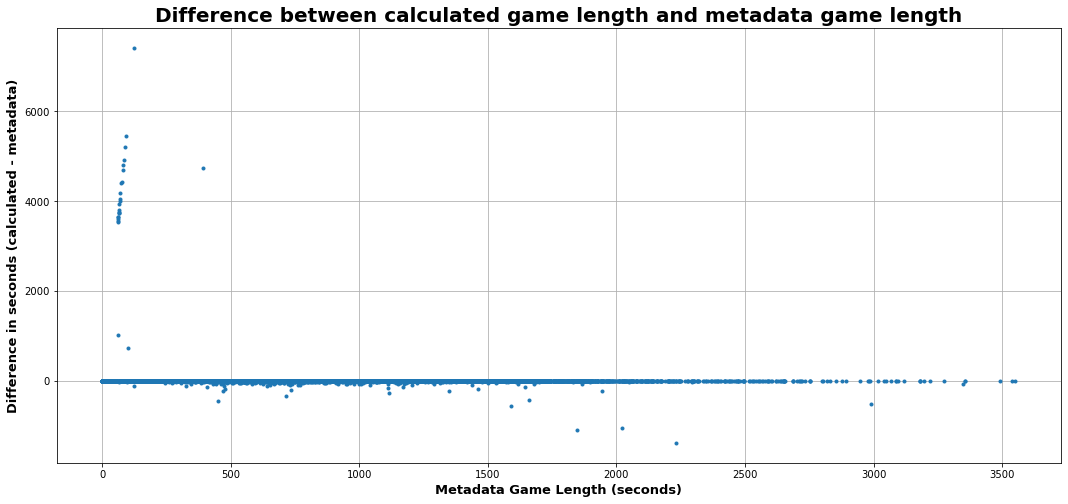

In [30]:
# create a dataframe from the list of results
length_calc_df = pd.DataFrame(
    length_calc_results, 
    columns=[
        'filehash', 
        'calculated_game_length', 
        'metadata_game_length', 
        'diff'
    ]
)

# index the dataframe by filehash
length_calc_df.set_index('filehash', inplace=True)

# plot diff as a function of metadata_gametime
plt.figure()
plt.plot(
    length_calc_df['metadata_game_length'],
    length_calc_df['diff'],
    '.'
)
plt.xlabel('Metadata Game Length (seconds)')
plt.ylabel('Difference in seconds (calculated - metadata)')
plt.title('Difference between calculated game length and metadata game length')
plt.grid()
plt.show() 

Most calculated game lengths appear to be within 1 or 2 seconds of the game length in the Metadata. There is one section of games that are following a trend of difference being proportional to Metadata game length. These should be investigated further.


In [31]:
# collect a list of filehashes that have a difference greater than 2000 seconds
list_of_bad_filehashes = length_calc_df[
    length_calc_df['diff'] > 2000
].index.tolist()

# create a dataframe of the bad filehashes
bad_filehashes = spawningtool_df.loc[
    spawningtool_df['filehash'].isin(list_of_bad_filehashes)
].set_index('filehash')

# add length_calc_df columns to bad_filehashes
bad_filehashes = pd.merge(
    bad_filehashes,
    length_calc_df,
    how='left',
    left_index=True,
    right_index=True
)

bad_filehashes

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,calculated_game_length,metadata_game_length,diff
filehash,,,,,,,,,,,,,,,,,,,
14e24170fe2892b44d6726304665a68cc0e7d4a6c3354ddac13c3e913389df42,data/SpawningTool/Other/page1000/cerulean-fall...,7af6ad6902e1b8f0258c1430a47c64b70d5d8a16a91858...,Terran,Protoss,NaN,NaN,61,1v1,Faster,0,2019-01-22 01:31:37,16.0,False,us,0,0,3712.0,61,3651
6a92f0ef6805672b32984032b35ad00cefe8f63b46fd71f90f1e0f3e6aa61ad9,data/SpawningTool/Other/page1001/craziest-game...,e6a70a47d9ee6b0bf8bcc1dbfc725c79f6d0d166f85993...,Zerg,Protoss,3704.0,3704.0,63,1v1,Faster,2,2019-01-15 05:27:28,16.0,True,us,5,5,3805.0,63,3742
a9c466e33bdfe0b0566a3d44765fefbfcdb7cd7c9d1d93c83a64e5f7a2e4a30f,data/SpawningTool/Other/page104/neeb-v-scarlet...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Protoss,Zerg,NaN,NaN,68,1v1,Faster,1,2021-05-29 22:46:59,16.0,False,us,0,0,4123.0,68,4055
5dfe15e7f9faee98471f3bb557afe240e2f845303f0fc0d4040d8400328ed749,data/SpawningTool/Other/page109/rex-v-game-4-j...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,NaN,NaN,66,1v1,Faster,2,2021-05-22 14:02:59,16.0,False,kr,0,0,3997.0,66,3931
1ca79c113cc626b05f3c0fcc0c3fe87778d4fd5d75417911906afb81b74c4483,data/SpawningTool/Other/page146/polka-le-108.S...,5bb01dd30ef93266a2d4c33e2ffc82b65e51746eeae5a3...,Protoss,Protoss,3509.0,3509.0,61,2v2,Faster,0,2021-02-25 22:57:49,16.0,True,eu,5,4,3703.0,61,3642
2d484149bd8277c06dd783365a4eec00f79125dd8d512fbb8f49871cfd5bdd1c,data/SpawningTool/Other/page312/gs-04-risky-vs...,817a7d97e089642e25f9ac718158074d40e1d1833ba1ff...,Protoss,Zerg,NaN,NaN,63,1v1,Faster,2,2020-10-16 08:22:01,16.0,False,eu,0,0,3798.0,63,3735
1b4f992e34b82687804c05bef02c1b7dab0fc29351ea2d8c6688eada6d146512,data/SpawningTool/Other/page325/jagannatha-le-...,0d7d9c441036e76bbb41f62e2dd8d562b8fa567e475fc2...,Terran,Terran,NaN,NaN,83,1v1,Faster,0,2020-11-05 00:51:56,16.0,False,us,0,0,4996.0,83,4913
7b3b07b710a3371ec4c42f92d9fcd461b33eed45d136bb8cde92a6507bcd6654,data/SpawningTool/Other/page330/ilativ-v-rotte...,81a673febf5dab0be0b70be74838ad6dacbf1b3ac338cc...,Zerg,Terran,2506.0,2442.0,88,1v1,Faster,2,2020-10-07 22:20:01,16.0,True,eu,0,3,5299.0,88,5211
8eacf407facb968d55c4c97a7ea6ecd5934a086ed09e70979ec81faffce0ce97,data/SpawningTool/Other/page393/mrfercho-v-tig...,09e460e152042c0526be61628563128162f24b41248b3f...,Zerg,Terran,NaN,NaN,60,4v4,Faster,1,2019-07-09 03:34:03,16.0,False,us,0,0,3600.0,60,3540


Cases with large differences are generally cases where metadata game length is a factor of approximately 60 times smaller than the calculated game length. Test this by plotting 60 $\times$ `metadata_game_length` vs `calculated_game_length` for these cases.

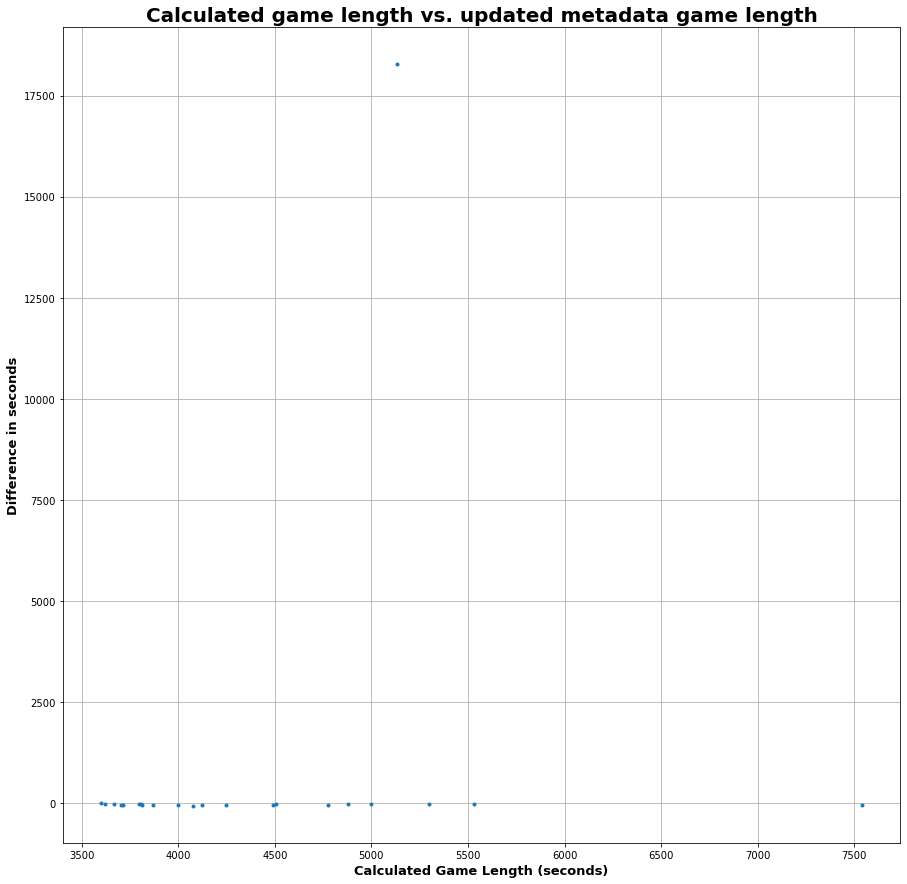

In [32]:
plt.figure(figsize=(15, 15))
plt.plot(
    bad_filehashes['calculated_game_length'],
    bad_filehashes['metadata_game_length']*60-bad_filehashes['calculated_game_length'],
    '.'
)
plt.xlabel('Calculated Game Length (seconds)')
plt.ylabel('Difference in seconds')
plt.title('Calculated game length vs. updated metadata game length')
plt.grid()
plt.show()


This confirms that metadata game length is occasionally stored in minutes instead of seconds for some games. It seems that in general, the game length calculated from the number of frames is a better estimate of the game length:
* First because the number of frames is a necessary property of the processing of the game (i.e. the replay would not work without it).
* Second because it would theoretically be possible that the game length in Metadata is longer than the calculated game length in cases where, after the game was complete, one player remained connected in the game, but taking no actions.

As a result of this, game length in Metadata will be updated for each replay in both datasets by using the calculated game length.

Only SpawningTool Metadata will be updated with the calculated game length, because doing this for Blizzard games would require processing each replay at `load_level=4` to calculate the game length, which is estimated to take around 27 hours of continuous processing time on a 6 core machine.

In [33]:
def update_metadata_game_length(row, df):
    """
    Function to update the game length in the metadata dataframe.
    This function is written to be used in an apply statement.
    It expects a row for the metadata and a dataframe of the new game lengths,
    indexed by filehash.

    Args:
        row (pandas.Series): row from the metadata dataframe
        df (pandas.DataFrame): dataframe of new game lengths indexed by filehash

    Returns:
        pandas.Series: row from the metadata dataframe with the new game length
    """

    # get the filehash from the row
    filehash = row['filehash']

    # get the new game length from the dataframe
    game_length = df.loc[filehash, 'calculated_game_length']

    # update the game length in the metadata dataframe
    row['game_length'] = game_length

    return row

# use partial to specify the dataframe as an argument and then use apply
func_part = partial(update_metadata_game_length, df=length_calc_df)

# use apply to update the metadata
spawningtool_df = spawningtool_df.apply(func_part, axis=1)

The game length in SpawningTool Metadata is now updated to being calculated from the number of frames.

#### Cleaning example replay file

We can now proceed to cleaning the event data of our example replay file. First we will examine the metadata to familiarize ourselves with the game.

In [35]:
# create a function to quickly display a summary of the current game's metadata
def display_metadata_summary(df, this_hash):
    """
    Function to quickly display a summary of the current game's metadata.
    This function is written to be used in an apply statement.
    It expects a dataframe of the metadata and a filehash.
    It prints the summary to the console and returns the row from the dataframe.

    Args:
        df (pandas.DataFrame): dataframe of the metadata
        hash (str): filehash of the current game

    Returns:
        pandas.Series: row from the metadata dataframe with the new game length
    """

    # get the row from the dataframe
    row = df.loc[df['filehash'] == this_hash]

    # print the player races
    print(f'Player 1    - {row["player1_race"].values[0]}')
    print(f'Player 2    - {row["player2_race"].values[0]}')

    # print game type
    print(f'Game type   - {row["game_type"].values[0]}')

    # convert game_length to hh:mm:ss and print
    time_string = time.strftime(
        '%H:%M:%S', 
        time.gmtime(int(row['game_length']))
    )
    print(f'Game length - {time_string}')

    # print game date and region
    print(f'Game date   - {row["timestamp"].values[0]}')
    print(f'Game region - {row["region"].values[0]}')

    # print which player won the game
    print(f'Game winner - Player {row["game_winner"].values[0]}')

    return row


In [36]:
# get the metadata for this replay by extracting the row where the filehash matches
game_info = display_metadata_summary(spawningtool_df, game_hash)


Player 1    - Protoss
Player 2    - Zerg
Game type   - 1v1
Game length - 00:44:48
Game date   - 2021-02-22T16:13:10.000000000
Game region - us
Game winner - Player 2


In [37]:
# get filename for the current replay from spawningtool_df
filename = spawningtool_df.loc[
    spawningtool_df['filehash'] == game_hash, 'filename'
].values[0]

# get the event data for this replay using process_events
event_df = get_all_events(filename, return_data=True)
event_df

,frame,name,pid,second,sid,type,uid,count,upgrade_type_name,control_pid,unit_id,unit_id_index,unit_id_recycle,unit_type_name,upkeep_pid,food_made,food_used,minerals_collection_rate,minerals_current,minerals_killed,minerals_killed_army,minerals_killed_economy,minerals_killed_technology,minerals_lost,minerals_lost_army,minerals_lost_economy,minerals_lost_technology,minerals_used_active_forces,minerals_used_current,minerals_used_current_army,minerals_used_current_economy,minerals_used_current_technology,minerals_used_in_progress,minerals_used_in_progress_army,minerals_used_in_progress_economy,minerals_used_in_progress_technology,resources_killed,resources_lost,resources_used_current,resources_used_in_progress,vespene_collection_rate,vespene_current,vespene_killed,vespene_killed_army,vespene_killed_economy,vespene_killed_technology,vespene_lost,vespene_lost_army,vespene_lost_economy,vespene_lost_technology,vespene_used_active_forces,vespene_used_current,vespene_used_current_army,vespene_used_current_economy,vespene_used_current_technology,vespene_used_in_progress,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology,workers_active_count,bank,control_group,mask_type,subgroup_index,ability_id,ability_link,ability_name,ability_type,command_index,flags,has_ability,ability_data,control_player_id,target_flags,target_timer,target_unit_id,target_unit_type,upkeep_player_id,hotkey,update_type,first_unit_index,killer_pid,killing_player_id,killing_unit_id,killing_unit_index,killing_unit_recycle,target,text
0,0,PlayerSetupEvent,1.0,0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,PlayerSetupEvent,2.0,0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,MineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,262145.0,1.0,1.0,PurifierVespeneGeyser,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,524289.0,2.0,1.0,PurifierMineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183027,60202,UnitBornEvent,NaN,3762,NaN,NaN,NaN,NaN,NaN,2.0,72089731.0,275.0,131.0,Broodling,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

First we will set the index of the dataframe to the frames column. This will make it easier to work with missing frames when we forward fill later on, and also will create more sensible indices (i.e. they will be refering to something in particular other than just a row number).

In [38]:
# set index of event_df to frame
event_df.set_index('frame', inplace=True)
event_df

,name,pid,second,sid,type,uid,count,upgrade_type_name,control_pid,unit_id,unit_id_index,unit_id_recycle,unit_type_name,upkeep_pid,food_made,food_used,minerals_collection_rate,minerals_current,minerals_killed,minerals_killed_army,minerals_killed_economy,minerals_killed_technology,minerals_lost,minerals_lost_army,minerals_lost_economy,minerals_lost_technology,minerals_used_active_forces,minerals_used_current,minerals_used_current_army,minerals_used_current_economy,minerals_used_current_technology,minerals_used_in_progress,minerals_used_in_progress_army,minerals_used_in_progress_economy,minerals_used_in_progress_technology,resources_killed,resources_lost,resources_used_current,resources_used_in_progress,vespene_collection_rate,vespene_current,vespene_killed,vespene_killed_army,vespene_killed_economy,vespene_killed_technology,vespene_lost,vespene_lost_army,vespene_lost_economy,vespene_lost_technology,vespene_used_active_forces,vespene_used_current,vespene_used_current_army,vespene_used_current_economy,vespene_used_current_technology,vespene_used_in_progress,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology,workers_active_count,bank,control_group,mask_type,subgroup_index,ability_id,ability_link,ability_name,ability_type,command_index,flags,has_ability,ability_data,control_player_id,target_flags,target_timer,target_unit_id,target_unit_type,upkeep_player_id,hotkey,update_type,first_unit_index,killer_pid,killing_player_id,killing_unit_id,killing_unit_index,killing_unit_recycle,target,text
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,PlayerSetupEvent,1.0,0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PlayerSetupEvent,2.0,0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,MineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,262145.0,1.0,1.0,PurifierVespeneGeyser,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,524289.0,2.0,1.0,PurifierMineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60202,UnitBornEvent,NaN,3762,NaN,NaN,NaN,NaN,NaN,2.0,72089731.0,275.0,131.0,Broodling,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

##### Step 1: Separating data by player number

To make it easier to work with the data we will create 3 separate dataframes, one for each player and one with all other events (to investigate what might be left out). 

Assumptions:
* Any row that has to do with a player will have their player number in either the `pid`, `control_pid`, or `upkeep_pid` column.
* All events in a row are separate (i.e. no row contains information for both players)

Let us first ensure that we have the right "pid" columns identified by searching for all columns containing that string.

In [39]:
for col in event_df.columns:
    if ("pid" in str(col).lower()) or ("player_id" in str(col).lower()):
        print(col)

pid
control_pid
upkeep_pid
control_player_id
upkeep_player_id
killer_pid
killing_player_id


There is another column called `killer_pid` which we had not previously considered. It is not immediately clear if this would identify the player that killed the unit or the player whose unit was killed. The assumption is that it is identifying the killer, but let us examine the first row containing a value for this column.

In [40]:
# get the first rows of event_df where killer_pid is not nan
# display transpose to make reading easier
event_df.loc[event_df['killer_pid'].isnull() == False].head(5).T

frame,3544,4006,4023,4368,4456
name,UnitDiedEvent,UnitDiedEvent,UnitDiedEvent,UnitDiedEvent,UnitDiedEvent
pid,NaN,NaN,NaN,NaN,NaN
second,221,250,251,273,278
sid,NaN,NaN,NaN,NaN,NaN
type,NaN,NaN,NaN,NaN,NaN
uid,NaN,NaN,NaN,NaN,NaN
count,NaN,NaN,NaN,NaN,NaN
upgrade_type_name,NaN,NaN,NaN,NaN,NaN
control_pid,NaN,NaN,NaN,NaN,NaN
unit_id,66060289.0,68943873.0,69730305.0,69468162.0,66846721.0


From the above and from reading the `sc2reader` code, it seems that `killer_pid` is referring to the player that did the killing. We will include this column as a check for separating the dataframes. Columns with `player_id` appear to be duplications of the `pid` columns, and so it is likely that we will remove these.

In [41]:
# drop column with names containing the string "player_id"
event_df.drop(
    columns=event_df.filter(regex='player_id'),
    inplace=True
)
event_df.head()

,name,pid,second,sid,type,uid,count,upgrade_type_name,control_pid,unit_id,unit_id_index,unit_id_recycle,unit_type_name,upkeep_pid,food_made,food_used,minerals_collection_rate,minerals_current,minerals_killed,minerals_killed_army,minerals_killed_economy,minerals_killed_technology,minerals_lost,minerals_lost_army,minerals_lost_economy,minerals_lost_technology,minerals_used_active_forces,minerals_used_current,minerals_used_current_army,minerals_used_current_economy,minerals_used_current_technology,minerals_used_in_progress,minerals_used_in_progress_army,minerals_used_in_progress_economy,minerals_used_in_progress_technology,resources_killed,resources_lost,resources_used_current,resources_used_in_progress,vespene_collection_rate,vespene_current,vespene_killed,vespene_killed_army,vespene_killed_economy,vespene_killed_technology,vespene_lost,vespene_lost_army,vespene_lost_economy,vespene_lost_technology,vespene_used_active_forces,vespene_used_current,vespene_used_current_army,vespene_used_current_economy,vespene_used_current_technology,vespene_used_in_progress,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology,workers_active_count,bank,control_group,mask_type,subgroup_index,ability_id,ability_link,ability_name,ability_type,command_index,flags,has_ability,ability_data,target_flags,target_timer,target_unit_id,target_unit_type,hotkey,update_type,first_unit_index,killer_pid,killing_unit_id,killing_unit_index,killing_unit_recycle,target,text
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,PlayerSetupEvent,1.0,0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PlayerSetupEvent,2.0,0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,MineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,262145.0,1.0,1.0,PurifierVespeneGeyser,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,UnitBornEvent,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,524289.0,2.0,1.0,PurifierMineralField750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we can move data from `event_df` to each player's dataframe and check what remains.

In [42]:
# function to separate players 
def separate_players(row, columns, player_id):
    """
    This function returns True any column in columns contains player_id.
    This function is written to be used in an apply statement.
    It expects a row from the event dataframe and a list of columns to check.
    It returns True if player_id is found in any of the columns.

    Args:
        row (pandas.Series): row from the event dataframe
        columns (list): list of columns to check
        player_id (int): player id to check for

    Returns:
        bool: True if player_id is found in any of the columns
    """

    # check if player_id is in any of the columns
    for col in columns:
        if row[col] == player_id:
            return True

    return False

In [43]:
pid_checklist = [
    'pid',
    'control_pid',
    'upkeep_pid',
    'killer_pid'
]

# partial is used to define any constant args before using apply to loop through rows
# get all rows where any column in pid_checklist is 1
func_part = partial(separate_players, columns=pid_checklist, player_id=1)
player1_index = event_df.apply(func_part, axis=1).values

# get all rows where any column in pid_checklist is 2
func_part = partial(separate_players, columns=pid_checklist, player_id=2)
player2_index = event_df.apply(func_part, axis=1).values

# create an index of all cases where neither player1_index nor player2_index is 1
remainder_index = np.where(
    (player1_index == 0) & (player2_index == 0),
    True,
    False
)

In [44]:
# use indices to create the 3 dfs
player1_df = event_df.loc[player1_index]
player2_df = event_df.loc[player2_index]
remainder_df = event_df.loc[remainder_index]

# print the shape of each df
print(f'Player 1 dataframe shape - {player1_df.shape}')
print(f'Player 2 dataframe shape - {player2_df.shape}')
print(f'Remainder dataframe shape - {remainder_df.shape}')

Player 1 dataframe shape - (19256, 84)
Player 2 dataframe shape - (45705, 84)
Remainder dataframe shape - (4462, 84)


Now we can check what remains in `remainder_df` to see if any of it is relevant.

In [45]:
# start by checking which columns in the remainder_df have non nan values
remainder_df.loc[:, ~remainder_df.isnull().all(axis=0)]['name'].value_counts()


UnitTypeChangeEvent    2635
UnitDiedEvent           808
UnitDoneEvent           661
UnitPositionsEvent      203
UnitBornEvent           155
Name: name, dtype: int64

The events that have not been assigned to a player are all unit based events. It seems likely that during data extraction, some events are mislabeled as not having a `pid` when infact they do. We will now attempt to assign these events to the correct player.

First we will see how many can be assigned by matching units from `remainder_df` with units in each player's dataframe. We can test doing this using `unit_id` and `unit_type_name` to see which yields the most matches.

In [46]:
# get a list of unique unit_type_name and unit_id from remainder_df
remainder_unit_type = remainder_df['unit_type_name'].unique()
remainder_unit_id = remainder_df['unit_id'].unique()

count_unit_type = 0
count_unit_id = 0

# check matches in player dataframes
count_unit_id += np.isin(player1_df['unit_id'], remainder_unit_id).sum()
count_unit_id += np.isin(player2_df['unit_id'], remainder_unit_id).sum()

count_unit_type += np.isin(
    player1_df['unit_type_name'], 
    remainder_unit_type
).sum()
count_unit_type += np.isin(
    player2_df['unit_type_name'], 
    remainder_unit_type
).sum()

print(f'unit_id match count - {count_unit_id}')
print(f'unit_type_name match count - {count_unit_type}')

print(f'Unmatched unit_id count - {count_unit_id - len(remainder_unit_id)}')
print(f'Unmatched unit_type_name count - {count_unit_type - len(remainder_unit_type)}')

unit_id match count - 2098
unit_type_name match count - 869
Unmatched unit_id count - 424
Unmatched unit_type_name count - 830


In [47]:
remainder_unit_id = remainder_df['unit_id'].unique()
player1_unit_id = player1_df['unit_id'].unique()
player2_unit_id = player2_df['unit_id'].unique()

# check which value in remainder_unit_id is in player1_unit_id or player2_unit_id
both_player_unit_id = remainder_unit_id[np.isin(remainder_unit_id, player1_unit_id) | np.isin(remainder_unit_id, player2_unit_id)]

In [48]:
# display number remainder_df after removing rows with unit_id in remainder_unit_id
display(remainder_df.drop(
    remainder_df.loc[remainder_df['unit_id'].isin(both_player_unit_id)].index
).shape)

# print separating line
print('-' * 80)

# print the unique name values remaining
print('Unique event names remaining')
print('----------------------------')
remainder_df.drop(
    remainder_df.loc[remainder_df['unit_id'].isin(both_player_unit_id)].index
)['name'].unique()

(188, 84)

--------------------------------------------------------------------------------
Unique event names remaining
----------------------------


array(['UnitPositionsEvent'], dtype=object)

After matching with `unit_id` only `UnitPositionsEvent` events remain. These events are too granular to be meaningful in model training, and so we will remove them. A units position is unlikely to be impactful on the outcome of a game. Their actions once in position are far more impactful, and these are already captured.

Now we will assign events to the relevant player dataframe by matching the `unit_id` column, and then we can remove `remainder_df`, only working with the two player dataframes.

In [49]:
# assign correct pid to each row in remainder_df using np.where
remainder_df.loc[:, 'pid'] = np.where(
    remainder_df['unit_id'].isin(player1_unit_id),
    1,
    np.where(
        remainder_df['unit_id'].isin(player2_unit_id), 2, np.nan
    )
)


C:\Users\jared\anaconda3\envs\sc2\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [50]:
# add rows with pid 1 to player1_df and pid 2 to player2_df
player1_df = player1_df.append(remainder_df.loc[remainder_df['pid'] == 1])
player2_df = player2_df.append(remainder_df.loc[remainder_df['pid'] == 2])

print(f'Player 1 dataframe shape - {player1_df.shape}')
print(f'Player 2 dataframe shape - {player2_df.shape}')


Player 1 dataframe shape - (21287, 84)
Player 2 dataframe shape - (48088, 84)


We have reduced the number of dataframes down to two. We can now process the dataframes in parallel. On initial inspection there are many rows with frame index of 0 which are just setup events. These rows can be removed, as the players would not yet have taken any actions, and the game setup is always the same.

In [51]:
# remove rows with index of 0 from player1_df and player2_df
player1_df.drop(0, inplace=True)
player2_df.drop(0, inplace=True)

display(player1_df.head())

# print a separating line
print('-' * 80)

# print the shapes of each df
print(f'Player 1 dataframe shape - {player1_df.shape}')
print(f'Player 2 dataframe shape - {player2_df.shape}')

,name,pid,second,sid,type,uid,count,upgrade_type_name,control_pid,unit_id,unit_id_index,unit_id_recycle,unit_type_name,upkeep_pid,food_made,food_used,minerals_collection_rate,minerals_current,minerals_killed,minerals_killed_army,minerals_killed_economy,minerals_killed_technology,minerals_lost,minerals_lost_army,minerals_lost_economy,minerals_lost_technology,minerals_used_active_forces,minerals_used_current,minerals_used_current_army,minerals_used_current_economy,minerals_used_current_technology,minerals_used_in_progress,minerals_used_in_progress_army,minerals_used_in_progress_economy,minerals_used_in_progress_technology,resources_killed,resources_lost,resources_used_current,resources_used_in_progress,vespene_collection_rate,vespene_current,vespene_killed,vespene_killed_army,vespene_killed_economy,vespene_killed_technology,vespene_lost,vespene_lost_army,vespene_lost_economy,vespene_lost_technology,vespene_used_active_forces,vespene_used_current,vespene_used_current_army,vespene_used_current_economy,vespene_used_current_technology,vespene_used_in_progress,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology,workers_active_count,bank,control_group,mask_type,subgroup_index,ability_id,ability_link,ability_name,ability_type,command_index,flags,has_ability,ability_data,target_flags,target_timer,target_unit_id,target_unit_type,hotkey,update_type,first_unit_index,killer_pid,killing_unit_id,killing_unit_index,killing_unit_recycle,target,text
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,PlayerStatsEvent,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,12.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,PlayerStatsEvent,1.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,13.0,335.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,1000.0,0.0,50.0,0.0,50.0,0.0,0.0,0.0,1000.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,CameraEvent,1.0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,CameraEvent,1.0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,CameraEvent,1.0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
Player 1 dataframe shape - (21199, 84)
Player 2 dataframe shape - (47988, 84)


Next we can remove redundant or unnecessary columns:
1. We will start by examining the `name` column and removing any rows that belong to unnecessary events.
2. We can then remove uninformative columns such as second, and columns that contain no data (all NaN)

At the end of the process, we will record a list of relevant columns, and event names. Then when creating the programatic version of this code that will be used to process the entire dataset, we can use this master list to remove columns. 

It makes sense to embed the data cleaning process into the `process_events.py` script, so we will create a class to handle the cleaning process and then import that class into `process_events.py`. This would result in a cleaner initial dataset, and less wasted space in storing the sparse files. For future work this would be a starting point.

##### Step 2: Removing unnecessary events and columns

In [52]:
# list unique event names in player1_df and player2_df
# use set() to extract unique values from the combined list of player1_df and 
# player2_df unique event names
unique_event_names = list(set(player1_df['name'].unique().tolist() + player2_df['name'].unique().tolist()))

print(f'{len(unique_event_names)} unique event names found')
print('-' * 80)
for event_name in unique_event_names:
    print(event_name)

22 unique event names found
--------------------------------------------------------------------------------
UnitDiedEvent
PlayerLeaveEvent
TargetPointCommandEvent
PlayerStatsEvent
ChatEvent
CameraEvent
UnitPositionsEvent
BasicCommandEvent
UnitDoneEvent
UnitTypeChangeEvent
UnitInitEvent
AddToControlGroupEvent
UnitOwnerChangeEvent
ControlGroupEvent
UpdateTargetPointCommandEvent
UnitBornEvent
GetControlGroupEvent
UpgradeCompleteEvent
SelectionEvent
UpdateTargetUnitCommandEvent
TargetUnitCommandEvent
SetControlGroupEvent


In [53]:
player1_df[player1_df['name'] == 'PlayerLeaveEvent'].head(10)

,name,pid,second,sid,type,uid,count,upgrade_type_name,control_pid,unit_id,unit_id_index,unit_id_recycle,unit_type_name,upkeep_pid,food_made,food_used,minerals_collection_rate,minerals_current,minerals_killed,minerals_killed_army,minerals_killed_economy,minerals_killed_technology,minerals_lost,minerals_lost_army,minerals_lost_economy,minerals_lost_technology,minerals_used_active_forces,minerals_used_current,minerals_used_current_army,minerals_used_current_economy,minerals_used_current_technology,minerals_used_in_progress,minerals_used_in_progress_army,minerals_used_in_progress_economy,minerals_used_in_progress_technology,resources_killed,resources_lost,resources_used_current,resources_used_in_progress,vespene_collection_rate,vespene_current,vespene_killed,vespene_killed_army,vespene_killed_economy,vespene_killed_technology,vespene_lost,vespene_lost_army,vespene_lost_economy,vespene_lost_technology,vespene_used_active_forces,vespene_used_current,vespene_used_current_army,vespene_used_current_economy,vespene_used_current_technology,vespene_used_in_progress,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology,workers_active_count,bank,control_group,mask_type,subgroup_index,ability_id,ability_link,ability_name,ability_type,command_index,flags,has_ability,ability_data,target_flags,target_timer,target_unit_id,target_unit_type,hotkey,update_type,first_unit_index,killer_pid,killing_unit_id,killing_unit_index,killing_unit_recycle,target,text
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
60200,PlayerLeaveEvent,1.0,3762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 22 unique event names in the dataset. Below, we discuss the merits of each event and whether it should be included in the final dataset.

**Included events:**
* `UnitBornEvent` - A unit is created. Certain units may impact the outcome of the game more than others (i.e. worker vs marine).
* `UpgradeCompleteEvent` - An upgrade is completed. Upgrades have a large impact on the game.
* `PlayerStatsEvent` - This is expected to be the primary source of information for the model. Events of this type record the rate of mineral and vespene gas collection, as well as their current supply and spending.
* `UnitInitEvent` - Player begins construction of a unit or building. This would be useful for modeling as it would also indicate how often a unit is canceled (i.e. `UnitInitEvent` takes place with no `UnitDoneEvent`).
* `UnitDiedEvent` - A unit dies. Certain units may be impactful on the outcome of the game (such as workers or a major fighting unit).
* `UnitDoneEvent` - A unit or building is finished being built. This information could be informative for the model, as knowing when a player finishes building a defensive structure or new unit is important.

**Excluded events:**
* `UnitPositionsEvent` - From `sc2reader` documentation *"Generated every 15 seconds. Marks the positions of the first 255 units that were damaged in the last interval. If more than 255 units were damaged, then the first 255 are reported and the remaining units are carried into the next interval."*. It is possible that this event could be interesting in future work, but it would need to be combined with other metrics such as the positions of the bases and the camera locations the players are currently observing.
* `ChatEvent` - A player sends a chat message. This event could be interesting for studying how often a losing player types "gg" at the end of a game (which is considered courteous) but would not be very meaningful in modeling the game.
* `PlayerLeaveEvent` - Player leaves the game. This is the event that decides the outcome of the game, i.e. first player to leave the game loses, which is not useful in terms of making a prediction.
* `GetControlGroupEvent` - From `sc2reader` documentation *"Extends :class:`ControlGroupEvent` This event replaces the current selection with the contents of the control group. The mask data is used to limit that selection to units that are currently selectable"*. This event is not expected to be meaningful in predicting the outcome of the game.
* `UnitOwnerChangeEvent` - A unit changes ownership. There are very few units which would trigger this event. For example Neural Parasite by an Infestor temporarily transfers control of a unit to the Infestor's player.

**Events that could be used in new features:**
* `APM` - This is a new feature (Actions Per Minute). It is commonly believed in the StarCraft community that APM is a very important metric in determining the outcome of a game. To test this hypothesis, a new feature can be created which calculates the APM of each player based on the following events:
    * `SelectionEvent` - A player selects a unit. It is unlikely that this event would be meaningful for the model, as selections could be implied through the unit actions that are subsequently recorded. 
    * `SetControlGroupEvent` - A player sets up a control group.
    * `UpdateTargetPointCommandEvent` - From `sc2reader` documentation *"when the user changes the point of a unit. Appears to happen when a unit is moving and it is given a new command. It's possible there are other instances of this occurring"*. Not expected to be meaningful for the model.
    * `ControlGroupEvent` - A player activates a control group.
    * `TargetUnitCommandEvent` - A player issues a command with a target. It could be hypothesized that this would be informative. But, like `UnitPositionsEvent`, it does not directly reflect the game state.
    * `BasicCommandEvent` - A player issues a basic command. This event could be interesting in predicting the outcome of the game, but it would be difficult to determine what the command would be.
    * `AddToControlGroupEvent` - Similar to `SetControlGroupEvent`, but when a player adds a unit to an existing control group.
    * `UnitInitEvent` - Discussed above.
    * `TargetPointCommandEvent` - Similar to `TargetUnitCommandEvent` but when the target is a point on the map instead of a unit. Might be useful for future modeling.
    * `UpdateTargetUnitCommandEvent` - An extension of `TargetUnitCommandEvent`. This event is not expected to be meaningful in predicting the outcome of the game.
    * `UnitTypeChangeEvent` - A unit changes type. There are many units in the game that have different forms (i.e. vikings can be in flying mode or landed mode). This event refers to a player action, and so can be used to calculate APM.
* `SPM` - Another metric that is often discussed in the community is Screens Per Minute. This measures how many new screens are observed per minute (i.e. how many completely new locations a player observes in a minute). SPM will not be directly calculated (that would involve checking the postion of each and every screen to see how many unique screens there are), but a version of this could be calculated by merely measuring the number of times a screen moves per minute:
    * `CameraEvent` - A player moves the location they are observing. This could be informative in seeing how player movement affects perception of the game. It will be included for now, but would have to be converted into a feature such as "number of camera movements per frame" which would be more meaningful.


In [54]:
# create a list of feature event names
feature_event_names = [
    'SelectionEvent', 
    'SetControlGroupEvent',
    'UpdateTargetPointCommandEvent',
    'ControlGroupEvent',
    'TargetUnitCommandEvent',
    'UnitPositionsEvent',
    'BasicCommandEvent',
    'AddToControlGroupEvent',
    'UnitInitEvent',
    'TargetPointCommandEvent',
    'UpdateTargetUnitCommandEvent',
    'UnitTypeChangeEvent'
]

# create player 1 and 2 feature dataframes
player1_features = player1_df.loc[player1_df['name'].isin(feature_event_names)]
player2_features = player2_df.loc[player2_df['name'].isin(feature_event_names)]

# print the shapes of each df
print(f'Player 1 features dataframe shape - {player1_features.shape}')
print(f'Player 2 features dataframe shape - {player2_features.shape}')

Player 1 features dataframe shape - (1830, 84)
Player 2 features dataframe shape - (12275, 84)


In [55]:
# create a list of excluded event names
excluded_event_names = [
    'UnitPositionsEvent',
    'ChatEvent',
    'PlayerLeaveEvent',
    'GetControlGroupEvent',
    'UnitOwnerChangeEvent'
]

# drop excluded and feature event names from player1_df and player2_df
player1_df.drop(
    player1_df[player1_df['name'].isin(
        excluded_event_names + feature_event_names
    )].index,
    inplace=True
)
player2_df.drop(
    player2_df[player2_df['name'].isin(
        excluded_event_names + feature_event_names
    )].index,
    inplace=True
)

# check the unique event names in player1_df and player2_df
remaining_event_names = list(set(player1_df['name'].unique().tolist() + player2_df['name'].unique().tolist()))

# print the shapes of each df
print(f'Player 1 dataframe shape - {player1_df.shape}')
print(f'Player 2 dataframe shape - {player2_df.shape}')


Player 1 dataframe shape - (18832, 84)
Player 2 dataframe shape - (19500, 84)


In [56]:
# print the unique event names remaining
print('Unique event names remaining')
print('----------------------------')
for event_name in remaining_event_names:
    print(event_name)


Unique event names remaining
----------------------------
CameraEvent
UnitDiedEvent
UpgradeCompleteEvent
UnitDoneEvent
PlayerStatsEvent
UnitBornEvent


###### Removing unnecessary columns
We will start by inspecting the list of columns to determine if any are clearly unnecessary or redundant.

In [57]:
# list all columns in player1_df
for col in player1_df.columns:
    print(col)

name
pid
second
sid
type
uid
count
upgrade_type_name
control_pid
unit_id
unit_id_index
unit_id_recycle
unit_type_name
upkeep_pid
food_made
food_used
minerals_collection_rate
minerals_current
minerals_killed
minerals_killed_army
minerals_killed_economy
minerals_killed_technology
minerals_lost
minerals_lost_army
minerals_lost_economy
minerals_lost_technology
minerals_used_active_forces
minerals_used_current
minerals_used_current_army
minerals_used_current_economy
minerals_used_current_technology
minerals_used_in_progress
minerals_used_in_progress_army
minerals_used_in_progress_economy
minerals_used_in_progress_technology
resources_killed
resources_lost
resources_used_current
resources_used_in_progress
vespene_collection_rate
vespene_current
vespene_killed
vespene_killed_army
vespene_killed_economy
vespene_killed_technology
vespene_lost
vespene_lost_army
vespene_lost_economy
vespene_lost_technology
vespene_used_active_forces
vespene_used_current
vespene_used_current_army
vespene_used_curr

The columns were evaluated by searching for "self.\<column name\>" in the code for `sc2reader`. Columns that can be removed from the outset are:
* All columns containing `pid` information - we have already segregated the dataframes by player id.
* `second` - this information can be inferred from the `frame` column.
* `control_group` - while we are interested in tracking player usage of control groups, we are not likely to be interested in their actual numbering.
* `command_index` - we are going to be tracking only the amount of commands issued (APM), so it is not necessary to know their type.
* `target_flags`, `target_timer`, `target_unit_id`, `target_unit_type` - we are not interested in specific actions targets, so we will remove these columns.
* `hotkey` - this tracks which hotkey is used for control groups and is not needed for our analysis.
* `update_type` - this is not needed for our analysis as it is just refering to how control groups are updated (i.e. adding or removing units).
* `first_unit_index` - this is the index used in tracking damaged units, and so is not part of the analysis.
* `target` - this is the target for a command, and so is not part of the analysis.
* `text` - a text log of the `ChatEvents`, not needed for our analysis.
* `uid` and `sid` - are unique identifiers for units and entities within the game, as such they are not needed for our analysis.
* `unit_id`, `unit_id_index`, `unit_id_recycle` - these columns all seem to be unit identifiers, `unit_type_name` is kept (it is more informative as a feature) and these are removed.
* `count` - this is the amount of times an upgrade has been researched, this is redundant information, and can be gained from `upgrade_type_name`.
* `bank` - this is a deprecate part of the `ControlGroupEvent` type.
* `mask_type` - a mask attribute that is used during the extraction of the event data by `sc2reader`.
* `subgroup_index` - it is uncertain what this refers to, but it is part of the `SelectionEvent` type and so is not needed for our analysis.
* `flags` - this is an attribute used during the extraction of the event data by `sc2reader`.
* `has_ability` - a flag that marks that a unit has an ability, but we are not interested in this information.
* `ability_data` - this seems unlikely to contain useful information, as it is only a marker containing information about the ability.
* `killer_pid`, `killing_unit_id`, `killing_unit_index`, `killing_unit_recycle` - these appear to be identifiers for the unit that killed the unit being tracked. It is unlikely that any will be needed, but they will be investigated further to confirm.
* `ability_id`, `ability_link`, `ability_name`, `ability_type` - we are not directly tracking any player abilities, so these columns will be removed.









In [58]:
# create a list of columns to keep in dataframes
columns_to_drop = [
    'second',
    'type',
    'control_group',
    'command_index',
    'target_flags', 'target_timer', 'target_unit_id', 'target_unit_type',
    'hotkey',
    'update_type',
    'first_unit_index',
    'target',
    'text',
    'uid', 'sid',
    'unit_id', 'unit_id_index', 'unit_id_recycle',
    'count',
    'bank',
    'mask_type',
    'subgroup_index', 
    'flags',
    'has_ability',
    'ability_data',
    'killer_pid', 'killing_unit_id', 'killing_unit_index', 'killing_unit_recycle',
    'ability_id', 'ability_link', 'ability_name', 'ability_type'
]

# subtract this from the column list in player1_df to get the columns to keep
columns_to_keep = [col for col in player1_df.columns if col not in columns_to_drop]

# print count of columns to keep
print(f'{len(columns_to_keep)} columns to keep')
print('-' * 80, end='\n\n')
for col in columns_to_keep:
    print(col)


51 columns to keep
--------------------------------------------------------------------------------

name
pid
upgrade_type_name
control_pid
unit_type_name
upkeep_pid
food_made
food_used
minerals_collection_rate
minerals_current
minerals_killed
minerals_killed_army
minerals_killed_economy
minerals_killed_technology
minerals_lost
minerals_lost_army
minerals_lost_economy
minerals_lost_technology
minerals_used_active_forces
minerals_used_current
minerals_used_current_army
minerals_used_current_economy
minerals_used_current_technology
minerals_used_in_progress
minerals_used_in_progress_army
minerals_used_in_progress_economy
minerals_used_in_progress_technology
resources_killed
resources_lost
resources_used_current
resources_used_in_progress
vespene_collection_rate
vespene_current
vespene_killed
vespene_killed_army
vespene_killed_economy
vespene_killed_technology
vespene_lost
vespene_lost_army
vespene_lost_economy
vespene_lost_technology
vespene_used_active_forces
vespene_used_current
vespen

We can now create a function to drop all but the above columns from our dataframes. We will create it such that a warning is raised if the column is not in the list of columns to keep, but ensure that the dataframe is still processed. This will allow us to batch process all replays at once, while tracking all dataframes where the columns are not uniform.

Warnings here will be informative to the differences between individual replay event data and allow for readjustment if the individual replay we have analyzed here is not representative of all replays.

We will write this as a function so that it can be used in future for bulk processing of the whole dataset.

In [59]:
# function to create a dataframe with only the columns to keep
# print warning if the dataframe does not contain necessary columns
# log warnings to file
def clean_columns_and_rows(
    df, 
    df_id, 
    cols,
    events,
    log_file="info/event_warnings.txt"):
    """
    This is a helper function which stores the list of events and columns to be 
    removed from a dataframe.
    It receives a dataframe, processes it and returns a dataframe with only the 
    columns and rows to keep.
    Expected columns and rows that are not found are logged to a file per 
    dataframe. 

    Args:
        df (dataframe): dataframe to be cleaned
        df_id (str): id of the dataframe, used to identify the dataframe in logs
        cols (list): list of columns to keep
        events (list): list of events to keep
        log_file (str): path to the file where warnings are logged

    Returns:
        dataframe: dataframe with only the columns and rows to keep

    """

    # generate keep_set a list of column from cols which are in df
    keep_set = set(cols).intersection(df.columns)

    # missing columns
    missing_columns = set(cols) - keep_set
        
    # check if the dataframe contains the necessary columns
    if len(missing_columns) > 0:
        # if not, log the event and columns to be removed to a file
        
        with open(log_file, 'a') as f:
            # get timestamp
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # log the event by timestamp and df_id
            f.write(f'{timestamp} - {df_id}\n')
            f.write(f'Dateframe shape - {df.shape}\n')
            f.write(f'Missing columns - {list(missing_columns)}\n\n')
            print(f'{timestamp} - {df_id}')
            print(f'Dateframe shape - {df.shape}')
            print(f'Missing columns - {list(missing_columns)}')

    # drop the columns that are not needed
    df = df[keep_set]

    # keep only rows with names in events
    df = df[df['name'].isin(events)]

    # return the dataframe with only the columns to keep
    return df


In [60]:
# define the lists of columns and events, these will be written to a file for reference later
columns_to_keep = [
        'name',
        'upgrade_type_name',
        'unit_type_name',
        'food_made',
        'food_used',
        'minerals_collection_rate',
        'minerals_current',
        'minerals_killed',
        'minerals_killed_army',
        'minerals_killed_economy',
        'minerals_killed_technology',
        'minerals_lost',
        'minerals_lost_army',
        'minerals_lost_economy',
        'minerals_lost_technology',
        'minerals_used_active_forces',
        'minerals_used_current',
        'minerals_used_current_army',
        'minerals_used_current_economy',
        'minerals_used_current_technology',
        'minerals_used_in_progress',
        'minerals_used_in_progress_army',
        'minerals_used_in_progress_economy',
        'minerals_used_in_progress_technology',
        'resources_killed',
        'resources_lost',
        'resources_used_current',
        'resources_used_in_progress',
        'vespene_collection_rate',
        'vespene_current',
        'vespene_killed',
        'vespene_killed_army',
        'vespene_killed_economy',
        'vespene_killed_technology',
        'vespene_lost',
        'vespene_lost_army',
        'vespene_lost_economy',
        'vespene_lost_technology',
        'vespene_used_active_forces',
        'vespene_used_current',
        'vespene_used_current_army',
        'vespene_used_current_economy',
        'vespene_used_current_technology',
        'vespene_used_in_progress',
        'vespene_used_in_progress_army',
        'vespene_used_in_progress_economy',
        'vespene_used_in_progress_technology',
        'workers_active_count'
    ]

# events to keep
player_events_to_keep = [
    'PlayerStatsEvent',
    'UnitBornEvent',
    'UnitDiedEvent',
    'UpgradeCompleteEvent',
    'UnitDoneEvent',
]

feature_events_to_keep = [
    'SelectionEvent', 
    'SetControlGroupEvent',
    'UpdateTargetPointCommandEvent',
    'ControlGroupEvent',
    'TargetUnitCommandEvent',
    'UnitPositionsEvent',
    'BasicCommandEvent',
    'AddToControlGroupEvent',
    'UnitInitEvent',
    'TargetPointCommandEvent',
    'UpdateTargetUnitCommandEvent',
    'UnitTypeChangeEvent',
    'CameraEvent'
    ]

We can write the above options to `raw_columns_list.csv` to be stored and used by the script which will process all replays. To do this we will add a new column called `clean_bool`, where a 1 will mean that a column should be kept, and a 0 will mean that the column should be dropped.

We will hardcode the event types that we are interested in, as these are unlikely to change, and to prevent having to keep track of too many settings files.

In [61]:
# fetch info/raw_columns_list.csv
raw_columns_list = pd.read_csv('info/raw_columns_list.csv')

# add two columns to raw_columns_list with all zero values
raw_columns_list['clean_bool'] = 0

# change value to 1 for all columns that are in columns_to_keep
for column_name in columns_to_keep:
    raw_columns_list.loc[
        raw_columns_list['column_name'] == column_name, 'clean_bool'
    ] = 1

# write the raw_columns_list to back to info/raw_columns_list.csv
raw_columns_list.to_csv('info/raw_columns_list.csv', index=False)

In [62]:
# use the function to clean the columns and rows from the dataframes
player1_df = clean_columns_and_rows(
    player1_df,
    'player1_df',
    columns_to_keep,
    player_events_to_keep
)
player2_df = clean_columns_and_rows(
    player2_df,
    'player2_df',
    columns_to_keep,
    player_events_to_keep
)
player1_features = clean_columns_and_rows(
    player1_features,
    'player1_features',
    columns_to_keep,
    feature_events_to_keep
)
player2_features = clean_columns_and_rows(
    player2_features,
    'player2_features',
    columns_to_keep,
    feature_events_to_keep
)

print(f'player1_df shape - {player1_df.shape}')
print(f'player2_df shape - {player2_df.shape}')
print(f'player1_features shape - {player1_features.shape}')
print(f'player2_features shape - {player2_features.shape}')



player1_df shape - (2790, 48)
player2_df shape - (15758, 48)
player1_features shape - (1830, 48)
player2_features shape - (12275, 48)


We will update `raw_columns_list.csv` with the columns that are to be kept. For each column we decide on the aggregation type that will be used (i.e. average or sum).

##### Step 3: Convert all columns to numeric
Now that we have only the features that we require, we can convert all columns to numeric. We will treat categorical columns by creating dummy variables for each class of the category. After this, we can combine all frames of the same number by summing dummy variable counts, and using aggregation for numeric columns.

We will create dummy variables only for columns in the player dataframes, the feature dataframes will be used to create the custom features we require and added back to the player dataframes.

A dummy variable is one that represents a single class of a categorical variable. If the dummy's class of the category is found, it stores a 1, otherwise it stores a 0.

In [63]:
# create a list of columns to create dummies by looking for object dtypes
object_dtypes = player1_df.select_dtypes(include=['object']).columns
object_dtypes

Index(['upgrade_type_name', 'unit_type_name', 'name'], dtype='object')

In [64]:
player1_df

,minerals_lost_army,resources_used_current,minerals_lost,vespene_used_in_progress_technology,minerals_used_current_army,vespene_lost_army,vespene_lost_economy,minerals_killed_technology,minerals_used_current_economy,vespene_used_current,vespene_lost,resources_used_in_progress,minerals_used_current_technology,minerals_current,vespene_killed_technology,food_used,vespene_used_in_progress_economy,vespene_used_in_progress_army,upgrade_type_name,vespene_used_current_technology,minerals_killed_army,minerals_used_in_progress,vespene_killed,unit_type_name,minerals_collection_rate,minerals_used_active_forces,vespene_used_active_forces,minerals_used_in_progress_army,vespene_current,vespene_used_current_economy,resources_killed,name,vespene_used_in_progress,minerals_lost_technology,minerals_used_in_progress_technology,food_made,resources_lost,workers_active_count,vespene_used_current_army,minerals_killed_economy,minerals_used_current,minerals_lost_economy,vespene_killed_army,minerals_used_in_progress_economy,minerals_killed,vespene_collection_rate,vespene_lost_technology,vespene_killed_economy
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,50.0,0.0,12.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PlayerStatsEvent,0.0,0.0,0.0,15.0,0.0,12.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,50.0,0.0,40.0,0.0,13.0,0.0,0.0,NaN,0.0,0.0,50.0,0.0,NaN,335.0,0.0,0.0,0.0,0.0,0.0,0.0,PlayerStatsEvent,0.0,0.0,0.0,15.0,0.0,12.0,0.0,0.0,1000.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Probe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnitBornEvent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,0.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,1050.0,0.0,0.0,50.0,0.0,65.0,0.0,14.0,0.0,0.0,NaN,0.0,0.0,50.0,0.0,NaN,643.0,0.0,0.0,0.0,0.0,0.0,0.0,PlayerStatsEvent,0.0,0.0,0.0,15.0,0.0,13.0,0.0,0.0,1050.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
480,0.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,1050.0,0.0,0.0,150.0,0.0,40.0,0.0,14.0,0.0,0.0,NaN,0.0,0.0,150.0,0.0,NaN,643.0,0.0,0.0,0.0,0.0,0.0,0.0,PlayerStatsEvent,0.0,0.0,0.0,15.0,0.0,13.0,0.0,0.0,1050.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnitDoneEvent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnitDoneEvent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnitDoneEvent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# create dummies for the columns in object_dtypes
player1_df = pd.get_dummies(player1_df, columns=object_dtypes)
print(f'player1_df shape - {player1_df.shape}')
player2_df = pd.get_dummies(player2_df, columns=object_dtypes)
print(f'player2_df shape - {player2_df.shape}')

player1_df shape - (2790, 90)
player2_df shape - (15758, 78)


We have created more columns in `player1_df` than `player2_df`, let us investigate the differences.

In [66]:
# print the difference between columns of player1_df and player2_df
different_columns = set(player1_df.columns) - set(player2_df.columns)
print('Column differences')
print('-' * 80, end='\n\n')
for col in different_columns:
    print(col)

Column differences
--------------------------------------------------------------------------------

unit_type_name_Interceptor
unit_type_name_ChangelingZealot
unit_type_name_DisruptorPhased
upgrade_type_name_ProtossGroundWeaponsLevel3
unit_type_name_Probe
upgrade_type_name_ProtossAirArmorsLevel1
unit_type_name_Phoenix
upgrade_type_name_DarkTemplarBlinkUpgrade
unit_type_name_Immortal
unit_type_name_Carrier
upgrade_type_name_WarpGateResearch
upgrade_type_name_ProtossShieldsLevel2
upgrade_type_name_TempestGroundAttackUpgrade
upgrade_type_name_BlinkTech
unit_type_name_ForceField
upgrade_type_name_ProtossGroundArmorsLevel2
upgrade_type_name_ProtossGroundWeaponsLevel1
upgrade_type_name_ProtossAirWeaponsLevel3
upgrade_type_name_Charge
unit_type_name_VoidRay
unit_type_name_Adept
upgrade_type_name_ProtossAirWeaponsLevel2
upgrade_type_name_PsiStormTech
upgrade_type_name_SprayProtoss
upgrade_type_name_ProtossGroundArmorsLevel1
unit_type_name_WarpPrism
upgrade_type_name_ProtossShieldsLevel1
unit_

The differences are due to different races for the two players. To combat this (for final modeling) we will create a set of columns across all replays and ensure that all dataframes have these columns (missing values filled with zeros) before modeling.

##### Step 4: Fill in missing frames and forward fill values

We will now create a function to fill in the missing frames and forward fill the values for all columns.

This function will first need to make sure that there are no duplicate frame numbers in the rows. To do this, we will create an internal function which checks `raw_columns_list.csv` for the type of aggregation that will be used for each column. In the case that no aggregation type is specified, we will assume that summation is correct.

In [67]:
def aggregate_frames(df):
    """
    Function to aggregate the frames in a dataframe.

    Args:
        df (pandas.DataFrame): The dataframe to aggregate.

    Returns:
        df (pandas.DataFrame): The aggregated dataframe.
    """
    
    # fetch column aggregation information from info/raw_columns_list.csv
    col_settings = pd.read_csv('info/raw_columns_list.csv')

    # set col_settings index to column_name
    col_settings.set_index('column_name', inplace=True)

    # create two lists, one for summation columns and one for mean agg types
    summation_columns = []
    mean_agg_columns = []

    # iterate over columns, checking their values in col_settings
    for col in df.columns:
        
        if col in col_settings.index:
            
            if col_settings.loc[col, 'agg_type'] == 'mean':
                mean_agg_columns.append(col)

        else:
            summation_columns.append(col)

    # create a new df with only the columns for each agg type
    df_summation = df[summation_columns]
    df_mean = df[mean_agg_columns]

    # aggregate the summation columns
    df_summation = df_summation.groupby(df_summation.index).sum()

    # aggregate the mean columns
    df_mean = df_mean.groupby(df_mean.index).mean()

    # concatenate the two dataframes
    df = pd.concat([df_summation, df_mean], axis=1)

    return df

In [68]:
# function to fill in missing frames and forward fill
def fill_missing_frames(df, max_frame, fill_type='ffill'):
    """
    Forward fill missing frames in a dataframe.

    Args:
        df (pandas.DataFrame): Dataframe to fill.
        max_frame (int): The maximum frame number. This is specified outside 
        the function because it is used to process player1 and 2 in parallel.
        fill_type (str): Type of fill to use.

    Returns:
        pandas.DataFrame: Dataframe with missing frames filled.
    """

    # assert that df is a dataframe
    assert isinstance(df, pd.DataFrame), 'df must be a pandas dataframe'

    # assert that df is indexed by frame
    assert 'frame' in df.index.names, 'df must be indexed by frame'

    # assert that fill_type is a string
    assert isinstance(fill_type, str), 'fill_type must be a string'
        
    # assert that fill_type is either 'ffill' or 'bfill'
    assert fill_type in ['ffill', 'bfill'], \
        f'fill_type must be either ffill or bfill, not {fill_type}'

    # assert that max_frame is an integer
    assert isinstance(max_frame, int), 'max_frame must be an integer'

    # create index range
    index_range = range(0, max_frame + 1)

    # insert frame 0 with all zeros
    df.loc[0] = 0

    # sort the dataframe by frame
    df = df.sort_index()

    # aggregate duplicate frames
    df = aggregate_frames(df)

    # forward fill nan values
    df = df.fillna(method=fill_type)

    # fill in the missing frames
    df = df.reindex(index_range, method=fill_type)

    # return the dataframe
    return df


In [69]:
# get the maximum frame of both player dfs
max_frame = max(player1_df.index.max(), player2_df.index.max())

# print player1_df shape
print(f'player1_df old shape - {player1_df.shape}')

# fill in missing frames in player1_df
player1_df = fill_missing_frames(player1_df, max_frame)

# print player1_df shape
print(f'player1_df new shape - {player1_df.shape}')

# print player2_df shape
print(f'player2_df old shape - {player2_df.shape}')

# fill in missing frames in player2_df
player2_df = fill_missing_frames(player2_df, max_frame)

# print player2_df shape
print(f'player2_df  new shape - {player2_df.shape}')

player1_df old shape - (2790, 90)
player1_df new shape - (60206, 90)
player2_df old shape - (15758, 78)
player2_df  new shape - (60206, 78)


In [70]:
# check for any nan in player1_df and player2_df
print(f'player1_df nan count - {player1_df.isna().sum().sum()}')
print(f'player2_df nan count - {player2_df.isna().sum().sum()}')


player1_df nan count - 0
player2_df nan count - 0


We now have two clean dataframes, one for each player. Feature creation and aggregation will be performed later, if required.

##### Step 5: Rename the columns by player number and combine the dataframes
We can combine the two dataframes once we have named each column by player number.

In [71]:
# function to rename columns and combine player1 and player2 dfs
def combine_player_dfs(player1_df, player2_df):
    """
    Rename player1 and player2 columns by inserting 'p1_' and 'p2_'
    respectively to the front of each column name.
    Then combine the two dataframes and return.

    Args:
        player1_df (pandas.DataFrame): Player1 dataframe.
        player2_df (pandas.DataFrame): Player2 dataframe.

    Returns:
        pandas.DataFrame: Combined dataframe.
    """

    # rename columns in player1_df
    player1_df.columns = ['p1_' + col for col in player1_df.columns]

    # rename columns in player2_df
    player2_df.columns = ['p2_' + col for col in player2_df.columns]

    # combine player1_df and player2_df
    df = pd.concat([player1_df, player2_df], axis=1)

    return df

combined_df = combine_player_dfs(player1_df, player2_df)
print(f'player1_df shape - {player1_df.shape}')
print(f'player2_df shape - {player2_df.shape}')
print(f'combined_df shape - {combined_df.shape}')
display(combined_df.head())



player1_df shape - (60206, 90)
player2_df shape - (60206, 78)
combined_df shape - (60206, 168)


,p1_upgrade_type_name_BlinkTech,p1_upgrade_type_name_Charge,p1_upgrade_type_name_DarkTemplarBlinkUpgrade,p1_upgrade_type_name_ProtossAirArmorsLevel1,p1_upgrade_type_name_ProtossAirArmorsLevel2,p1_upgrade_type_name_ProtossAirArmorsLevel3,p1_upgrade_type_name_ProtossAirWeaponsLevel1,p1_upgrade_type_name_ProtossAirWeaponsLevel2,p1_upgrade_type_name_ProtossAirWeaponsLevel3,p1_upgrade_type_name_ProtossGroundArmorsLevel1,p1_upgrade_type_name_ProtossGroundArmorsLevel2,p1_upgrade_type_name_ProtossGroundArmorsLevel3,p1_upgrade_type_name_ProtossGroundWeaponsLevel1,p1_upgrade_type_name_ProtossGroundWeaponsLevel2,p1_upgrade_type_name_ProtossGroundWeaponsLevel3,p1_upgrade_type_name_ProtossShieldsLevel1,p1_upgrade_type_name_ProtossShieldsLevel2,p1_upgrade_type_name_ProtossShieldsLevel3,p1_upgrade_type_name_PsiStormTech,p1_upgrade_type_name_SprayProtoss,p1_upgrade_type_name_TempestGroundAttackUpgrade,p1_upgrade_type_name_VoidRaySpeedUpgrade,p1_upgrade_type_name_WarpGateResearch,p1_unit_type_name_Adept,p1_unit_type_name_AdeptPhaseShift,p1_unit_type_name_Carrier,p1_unit_type_name_ChangelingZealot,p1_unit_type_name_Disruptor,p1_unit_type_name_DisruptorPhased,p1_unit_type_name_ForceField,p1_unit_type_name_Immortal,p1_unit_type_name_Interceptor,p1_unit_type_name_Mothership,p1_unit_type_name_Observer,p1_unit_type_name_Oracle,p1_unit_type_name_Phoenix,p1_unit_type_name_Probe,p1_unit_type_name_Tempest,p1_unit_type_name_VoidRay,p1_unit_type_name_WarpPrism,p1_name_PlayerStatsEvent,p1_name_UnitBornEvent,p1_name_UnitDiedEvent,p1_name_UnitDoneEvent,p1_name_UpgradeCompleteEvent,p1_minerals_lost_army,p1_resources_used_current,p1_minerals_lost,p1_vespene_used_in_progress_technology,p1_minerals_used_current_army,p1_vespene_lost_army,p1_vespene_lost_economy,p1_minerals_killed_technology,p1_minerals_used_current_economy,p1_vespene_used_current,p1_vespene_lost,p1_resources_used_in_progress,p1_minerals_used_current_technology,p1_minerals_current,p1_vespene_killed_technology,p1_food_used,p1_vespene_used_in_progress_economy,p1_vespene_used_in_progress_army,p1_vespene_used_current_technology,p1_minerals_killed_army,p1_minerals_used_in_progress,p1_vespene_killed,p1_minerals_collection_rate,p1_minerals_used_active_forces,p1_vespene_used_active_forces,p1_minerals_used_in_progress_army,p1_vespene_current,p1_vespene_used_current_economy,p1_resources_killed,p1_vespene_used_in_progress,p1_minerals_lost_technology,p1_minerals_used_in_progress_technology,p1_food_made,p1_resources_lost,p1_workers_active_count,p1_vespene_used_current_army,p1_minerals_killed_economy,p1_minerals_used_current,p1_minerals_lost_economy,p1_vespene_killed_army,p1_minerals_used_in_progress_economy,p1_minerals_killed,p1_vespene_collection_rate,p1_vespene_lost_technology,p1_vespene_killed_economy,p2_upgrade_type_name_AnabolicSynthesis,p2_upgrade_type_name_Burrow,p2_upgrade_type_name_DiggingClaws,p2_upgrade_type_name_EvolveGroovedSpines,p2_upgrade_type_name_EvolveMuscularAugments,p2_upgrade_type_name_InfestorEnergyUpgrade,p2_upgrade_type_name_SprayZerg,p2_upgrade_type_name_ZergFlyerArmorsLevel1,p2_upgrade_type_name_ZergFlyerArmorsLevel3,p2_upgrade_type_name_ZergFlyerWeaponsLevel1,p2_upgrade_type_name_ZergFlyerWeaponsLevel3,p2_upgrade_type_name_ZergGroundArmorsLevel2,p2_upgrade_type_name_ZergGroundArmorsLevel3,p2_upgrade_type_name_ZergMeleeWeaponsLevel1,p2_upgrade_type_name_ZergMeleeWeaponsLevel2,p2_upgrade_type_name_ZergMissileWeaponsLevel1,p2_upgrade_type_name_ZergMissileWeaponsLevel2,p2_upgrade_type_name_ZergMissileWeaponsLevel3,p2_upgrade_type_name_overlordspeed,p2_upgrade_type_name_zerglingmovementspeed,p2_unit_type_name_Broodling,p2_unit_type_name_BroodlingEscort,p2_unit_type_name_Changeling,p2_unit_type_name_InvisibleTargetDummy,p2_unit_type_name_Larva,p2_unit_type_name_ParasiticBombDummy,p2_unit_type_name_ParasiticBombRelayDummy,p2_unit_type_name_Queen,p2_name_PlayerStatsEvent,p2_name_UnitBornEvent,p2_name_UnitDiedEvent,p2_name_UnitDoneEvent,p2_name_UpgradeCompleteEvent,p2_minerals_lost_army,p2_r

###### Decide of format in which to store the data
Storing the clean dataframes to disk is required so that any further processing can be done on the data, as needed. We will decide on the format that gives the best balance of file size and speed of reading.

Below is the time taken for 4 different formats to be written to disk, and read back. And then the file size of each format is compared last.

In [72]:
%%timeit
combined_df.to_pickle(f'data/clean_events/{game_hash}.pkl')

25.1 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
combined_df.to_pickle(f'data/clean_events/{game_hash}.zip')

431 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
%%timeit
combined_df.to_csv(f'data/clean_events/{game_hash}.csv')

2.25 s ± 46.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%%timeit
combined_df.to_hdf(
    f'data/clean_events/{game_hash}.h5',
    key='df',
    complevel=1,
    complib='bzip2'
)

2.33 s ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%%timeit
pd.read_pickle(f'data/clean_events/{game_hash}.pkl')

18.8 ms ± 632 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
%%timeit
pd.read_pickle(f'data/clean_events/{game_hash}.zip')

169 ms ± 874 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
%%timeit
pd.read_csv(f'data/clean_events/{game_hash}.csv')

426 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%%timeit
pd.read_hdf(f'data/clean_events/{game_hash}.h5', key='df')

278 ms ± 8.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
# compare the filesize of the 3 files in MB
print(f'.pkl - {os.path.getsize(f"data/clean_events/{game_hash}.pkl") / 1000000} MB')
print(f'.zip - {os.path.getsize(f"data/clean_events/{game_hash}.zip") / 1000000} MB')
print(f'.csv - {os.path.getsize(f"data/clean_events/{game_hash}.csv") / 1000000} MB')
print(f'.h5 - {os.path.getsize(f"data/clean_events/{game_hash}.h5") / 1000000} MB')

.pkl - 80.92338 MB
.zip - 0.157793 MB
.csv - 42.862387 MB
.h5 - 0.38022 MB


`pd.to_pickle` with `.zip` extension appears to give the best balance of filesize and speed, with a 169ms read time and a 0.16MB file size, `.pkl` files are just too large, and would not allow for easy sharing of the cleaned data.

### 2.3 - Bulk Processing Event Data <a name="section-2-3"></a>

Now we can create the script that will be used to process all replays, and then run it.

In [183]:
%%writefile scripts/get_clean_events.py
"""
This file contains a function to get the clean events dataframe for a game.

Event data is read from a pkl or csv file, processed and then returned as a zipped pickle file.
"""

from functools import partial
import os
import pandas as pd
import numpy as np
from datetime import datetime

def _separate_players(row, columns, player_id):
    """
    Helper function to create indices for player1 and player2.
    
    Args:
        row (pandas.Series): Row of dataframe.
        columns (list): List of columns in dataframe that include pid info
        player_id (str): Player id.

    Returns:
        bool: True if player_id is in columns, False otherwise.
    """

    # check if player_id is in any of the columns
    for col in columns:
        # skip if col is not in columns
        if col not in row.index:
            continue

        # check if player_id is in col
        if row[col] == player_id:
            return True

    return False


def separate_player_dfs(df):
    """
    Separate the player1 and player2 dataframes from the combined dataframe.

    Args:
        df (pandas.DataFrame): Combined dataframe.

    Returns:
        pandas.DataFrame: Player1 dataframe.
        pandas.DataFrame: Player2 dataframe.
    """
    
    
    pid_checklist = [
        'pid',
        'control_pid',
        'upkeep_pid',
        'killer_pid'
    ]

    # get all rows where any column in pid_checklist is 1
    func_part = partial(_separate_players, columns=pid_checklist, player_id=1)
    player1_index = df.apply(func_part, axis=1).values

    # get all rows where any column in pid_checklist is 2
    func_part = partial(_separate_players, columns=pid_checklist, player_id=2)
    player2_index = df.apply(func_part, axis=1).values

    # create an index of all cases where neither player1_index or player2_index is 1
    remainder_index = np.where(
        (player1_index == 0) & (player2_index == 0),
        True,
        False
    )

    # use indices to create the 3 dfs
    player1_df = df.loc[player1_index]
    player2_df = df.loc[player2_index]
    remainder_df = df.loc[remainder_index]

    # check that unit_id column exists in player1_df and player2_df
    if 'unit_id' not in player1_df.columns or \
        'unit_id' not in player2_df.columns:
        print('WARNING: unit_id column does not exist in player1_df or player2_df')
        return None, None



    # match rows of remainder_df to either player1_df or player2_df
    # use unit_id as the matching key
    player1_unit_id = player1_df['unit_id'].unique()
    player2_unit_id = player2_df['unit_id'].unique()

    # assign correct pid to each row in remainder_df using np.where
    remainder_df.loc[:, 'pid'] = np.where(
        remainder_df['unit_id'].isin(player1_unit_id),
        1,
        np.where(
            remainder_df['unit_id'].isin(player2_unit_id), 2, np.nan
        )
    )

    # add rows with pid 1 to player1_df and pid 2 to player2_df
    player1_df = player1_df.append(remainder_df.loc[remainder_df['pid'] == 1])
    player2_df = player2_df.append(remainder_df.loc[remainder_df['pid'] == 2])

    # we now have 2 dfs, one for each player
    # we don't need the remainder_df anymore
    return player1_df, player2_df


def _clean_columns_and_rows(
    df, 
    df_id, 
    cols,
    events,
    log_file="info/event_warnings.txt"):
    """
    This is a helper function which stores the list of events and columns to be 
    removed from a dataframe.
    It receives a dataframe, processes it and returns a dataframe with only the 
    columns and rows to keep.
    Expected columns and rows that are not found are logged to a file per 
    dataframe. 

    Args:
        df (dataframe): dataframe to be cleaned
        df_id (str): id of the dataframe, used to identify the dataframe in logs
        cols (list): list of columns to keep
        events (list): list of events to keep
        log_file (str): path to the file where warnings are logged

    Returns:
        dataframe: dataframe with only the columns and rows to keep

    """

    # generate keep_set a list of column from cols which are in df
    keep_set = set(cols).intersection(df.columns)

    # missing columns
    missing_columns = set(cols) - keep_set
        
    # check if the dataframe contains the necessary columns
    if len(missing_columns) > 0:
        # if not, log the event and columns to be removed to a file
        
        with open(log_file, 'a') as file:
            # get timestamp
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # log the event by timestamp and df_id
            file.write(f'{timestamp} - {df_id}\n')
            file.write(f'Dateframe shape - {df.shape}\n')
            file.write(f'Missing columns - {list(missing_columns)}\n\n')

    # drop the columns that are not needed
    df = df[keep_set]

    # keep only rows with names in events
    df = df[df['name'].isin(events)]

    # return the dataframe with only the columns to keep
    return df


def clean_player_events(df, raw_columns_list, filehash, dummies_list_location):
    """
    This function cleans the player events dataframe.

    Any new dummies that are created which are not already in dummies_list, are added to dummies_list. If dummies_list is not present at the location specified it is created

    Args:
        df (pandas.Dataframe): dataframe to be cleaned
        raw_columns_list (pandas.Dataframe): index of columns and how to treat them
        filehash (string): hash of the file currently being processed, for logging purposes
        dummies_list_location (string): location of the dummies_list file, relative or absolute
    
    Returns:
        pandas.DataFrame: the cleaned dataframe
    """    
    # start by removing index=0 rows
    df.drop(0, inplace=True, errors='ignore')

    events_to_keep = [
        'PlayerStatsEvent',
        'UnitBornEvent',
        'UnitDiedEvent',
        'UnitDoneEvent',
        'UpgradeCompleteEvent'
    ]

    # extract column_name from raw_columns_list where clean_bool == 1
    columns_to_keep = raw_columns_list.loc[
        raw_columns_list['clean_bool'] == 1,
        'column_name'
    ].tolist()

    # clean the dataframes
    df = _clean_columns_and_rows(
        df,
        filehash,
        columns_to_keep,
        events_to_keep
    )

    # create a list of original column names in df
    original_columns = df.columns.to_list()

    # list of object column targets
    object_columns = ['upgrade_type_name', 'name', 'unit_type_name']
    # check that object columns are in df
    if not set(object_columns).issubset(set(df.columns)):
        print('WARNING: object columns are not in df')
        return None

    # convert object columns to numeric
    df = pd.get_dummies(df, columns=object_columns)

    # # create a list of column names in df that are not in original_columns
    # dummy_columns = pd.Series([
    #     col for col in df.columns.to_list() if col not in original_columns
    # ])   

    # # a dummies list is used to track all the possible values for each dummy
    # # get the location of the dummies list from settings
    # dummies_list_location = dummies_list_location

    # # append dummy_columns series to csv file
    # with open(dummies_list_location, 'a') as file:
    #     dummy_columns.to_csv(file, header=False, index=False)

    return df


def _aggregate_frames(df, max_frame, frame_size, columns_list):
    """
    Function to aggregate the frames in a dataframe.

    Args:
        df (pandas.DataFrame): The dataframe to aggregate.
        frame_size (int): The number of frames to aggregate.

    Returns:
        df (pandas.DataFrame): The aggregated dataframe.
        index_range(list): The range of indices to keep.
    """

    col_settings = columns_list.copy()

    # set col_settings index to column_name
    col_settings.set_index('column_name', inplace=True)

    # create two lists, one for summation columns and one for mean agg types
    summation_columns = []
    mean_agg_columns = []

    # iterate over columns, checking their values in col_settings
    for col in df.columns:
        
        if col in col_settings.index:
            
            if col_settings.loc[col, 'agg_type'] == 'mean':
                mean_agg_columns.append(col)

        else:
            summation_columns.append(col)

    # create a new df with only the columns for each agg type
    df_summation = df[summation_columns]
    df_mean = df[mean_agg_columns]

    # aggregate the summation columns
    df_summation = df_summation.groupby(df_summation.index).sum()

    # aggregate the mean columns
    df_mean = df_mean.groupby(df_mean.index).mean()

    # create index range
    index_range = range(0, max_frame + 1)

    if frame_size > 1:
        # calculate the number of bins that would be required 
        # to aggregate the dataframe into the desired frame_size
        num_bins = int(max_frame / frame_size) + 1

        # use pd.cut to group the dataframe by the number of bins
        df_summation = df_summation.groupby(
            pd.cut(df_summation.index, num_bins)
        ).sum()

        df_mean = df_mean.groupby(
            pd.cut(df_mean.index, num_bins)
        ).mean()

        # create a list of starting index for each bin
        bin_ends = [(i + 1)*frame_size - 1 for i in range(num_bins)]
        # check that the last bin ends at the max frame
        if bin_ends[-1] > max_frame:
            bin_ends[-1] = max_frame

        # index both dataframes by the bin starts
        df_summation.index = bin_ends
        df_mean.index = bin_ends

        # create a new index range
        index_range = bin_ends

    # concatenate the two dataframes
    df = pd.concat([df_summation, df_mean], axis=1)

    return df, index_range


def _remove_nan_values(df, fill_type):
    """
    Function to remove nan values from a dataframe.
    For dummy columns fill nan with 0 for other columns use fill_type

    Args:
        df (pandas.DataFrame): The dataframe to clean.

    Returns:
        df (pandas.DataFrame): The cleaned dataframe.
    """

    dummy_prefixes = []
    # create a list of prefixes for dummy columns
    for p in ['p1_', 'p2_']:
        for c in ['upgrade_type_name', 'name', 'unit_type_name']:
            dummy_prefixes.append(p + c)

    # find any columns that start with a dummy prefix
    dummy_columns = [c for c in df.columns if c.startswith(tuple(dummy_prefixes))]

    # if there are dummy columns, fill them with 0
    if dummy_columns:
        df.fillna(0, inplace=True)

    # fill df with fill_type
    df.fillna(method=fill_type, inplace=True)

    return df


def fill_missing_frames_and_agg(
    df, 
    max_frame, 
    frame_size, 
    columns_list,
    fill_type='ffill'
):
    """
    Forward fill missing frames in a dataframe. And aggregate the dataframe by frame_size.

    Args:
        df (pandas.DataFrame): Dataframe to fill.
        max_frame (int): The maximum frame number. This is specified outside 
        the function because it is used to process player1 and 2 in parallel.
        fill_type (str): Type of fill to use.

    Returns:
        pandas.DataFrame: Dataframe with missing frames filled.
    """

    # assert that df is a dataframe
    assert isinstance(df, pd.DataFrame), 'df must be a pandas dataframe'

    # assert that df is indexed by frame
    assert 'frame' in df.index.names, 'df must be indexed by frame'

    # assert that fill_type is a string
    assert isinstance(fill_type, str), 'fill_type must be a string'
        
    # assert that fill_type is either 'ffill' or 'bfill'
    assert fill_type in ['ffill', 'bfill'], \
        f'fill_type must be either ffill or bfill, not {fill_type}'

    # assert that max_frame is an integer
    assert isinstance(max_frame, int), 'max_frame must be an integer'

    # insert frame 0 with all zeros
    df.loc[0] = 0

    # sort the dataframe by frame
    df = df.sort_index()

    # aggregate duplicate frames
    df, index_range = _aggregate_frames(df, max_frame, frame_size, columns_list)

    df = _remove_nan_values(df, fill_type)

    # fill in the missing frames
    df = df.reindex(index_range, method=fill_type)

    # return the dataframe
    return df

def get_clean_events(
    filename, 
    return_df=False, 
    output_dir='data/clean_events',
    columns_list_location='info/raw_columns_list.csv',
    dummies_list_location='info/dummies_list.csv',
    frame_size=1
):
    """
    Get the clean events dataframe for a game from the raw dataframe. Stores the dataframe as a pickle file, using filehash as the filename.

    Args:
        filename (str): The filename (absolute or relative path) of the raw dataframe.
        return_df (bool): Return the dataframe if True, otherwise return nothing.
        output_dir (str): The directory to save the clean events dataframe.
        columns_list_location (str): The location of the raw_columns_list.csv file.
        dummies_list_location (str): The location of the dummies_list.csv file.
        frame_size (int): The number of frames to aggregate.

    Returns:
        pandas.DataFrame: The clean events dataframe if return_df is True.
    """

    # assert that file exists
    assert os.path.exists(filename), f'{filename} does not exist'

    # assert that return_df is a boolean
    assert isinstance(return_df, bool), 'return_df must be a boolean'

    # assert that output_dir is a string and exists
    assert isinstance(output_dir, str), 'output_dir must be a string'
    assert os.path.exists(output_dir), f'{output_dir} does not exist'

    # if dummies_list_location.csv does not exist, create it
    if not os.path.exists(dummies_list_location):
        # create blank dummies_list.csv
        with open(dummies_list_location, 'w') as f:
            pass

    # read the raw dataframe
    if filename.endswith('.pkl') or filename.endswith('.zip'):
        event_df = pd.read_pickle(filename)
    elif filename.endswith('.csv'):
        event_df = pd.read_csv(filename)
    else:
        raise ValueError(f'{filename} is not a valid filetype')

    # set index to frame
    event_df.set_index('frame', inplace=True)

    # get the filehash from the filename
    filehash = filename.split('/')[-1].split('.')[0]

    # get the location of raw_columns_list.csv and read it in
    raw_columns_list_path = columns_list_location

    # assert that the file exists
    assert os.path.exists(raw_columns_list_path), f'{raw_columns_list_path} does not exist'
    raw_columns_list = pd.read_csv(raw_columns_list_path)

    # separate the dataframes into player1 and player2
    player1_df, player2_df = separate_player_dfs(event_df)
    
    # check if either is None
    if player1_df is None or player2_df is None:
        return

    # clean the dataframes
    player1_df = clean_player_events(
        player1_df, 
        raw_columns_list, 
        filehash, 
        dummies_list_location
    )
    player2_df = clean_player_events(
        player2_df, 
        raw_columns_list, 
        filehash,
        dummies_list_location
    )
    # check if either is None
    if player1_df is None or player2_df is None:
        return

    # get max frames from player1 and player2
    max_frames = max(player1_df.index.max(), player2_df.index.max())

    # print warning if max_frames is not an integer or is less than 1
    if not isinstance(max_frames, int) or max_frames < 1:
        print(f'filehash: {filehash} - SKIPPING')
        print('WARNING: max_frames is not an integer or is less than 1')
        return

    # aggregate frames according to settings
    num_frames = frame_size

    # fill missing frames and aggregate
    player1_df = fill_missing_frames_and_agg(
        player1_df, 
        max_frames, 
        num_frames,
        raw_columns_list
    )
    player2_df = fill_missing_frames_and_agg(
        player2_df, 
        max_frames, 
        num_frames,
        raw_columns_list
    )

    # combine the dataframes
    player1_df.columns = ['p1_' + col for col in player1_df.columns]
    player2_df.columns = ['p2_' + col for col in player2_df.columns]

    # concatenate the dataframes
    event_df = pd.concat([player1_df, player2_df], axis=1)

    # define filename as zip for automatic pickle compression
    output_filename = f'{output_dir}/{filehash}.zip'

    # save the dataframe
    event_df.to_pickle(output_filename)

    # return the dataframe
    if return_df:
        return event_df


Overwriting scripts/get_clean_events.py


In [186]:
from scripts.get_clean_events import get_clean_events
%autoreload

# get list of files from spawningtool_df
filenames = [
    'data/events/' + i + '.zip' for i in spawningtool_df['filehash'].tolist()
]

total_replays = len(filenames)

if __name__ == '__main__':
    # get the clean events dataframe for each file
    processes = mp.cpu_count() - 1
    # use a frame size of 5 real-time seconds = 5*22.4 = 112 frames
    part_func = partial(get_clean_events, frame_size=112, return_df=True)
    with mp.Pool(processes=processes) as pool:
        results = list(tqdm(pool.imap(
                part_func,
                filenames,
                chunksize=10
            ),
            total=total_replays,
            desc='Getting clean events',
            unit='replays'
        ))

100%|██████████| 36812/36812 [30:26<00:00, 20.16it/s]


In [92]:
# remove None results from results list
results = [r for r in results if r is not None]
len(results)

36788

We successfully have extracted 36,788 of our 36,812 replays. We will consider this an acceptable return.

In [93]:
results[0].head()

,p1_upgrade_type_name_SprayTerran,p1_upgrade_type_name_Stimpack,p1_name_PlayerStatsEvent,p1_name_UnitBornEvent,p1_name_UnitDiedEvent,p1_name_UnitDoneEvent,p1_name_UpgradeCompleteEvent,p1_unit_type_name_Liberator,p1_unit_type_name_MULE,p1_unit_type_name_Marine,p1_unit_type_name_Medivac,p1_unit_type_name_Reaper,p1_unit_type_name_SCV,p1_unit_type_name_SiegeTank,p1_unit_type_name_VikingFighter,p1_minerals_lost_economy,p1_minerals_used_in_progress_army,p1_vespene_lost_technology,p1_vespene_lost,p1_vespene_used_in_progress,p1_minerals_collection_rate,p1_minerals_used_in_progress_technology,p1_vespene_collection_rate,p1_vespene_current,p1_resources_used_in_progress,p1_food_made,p1_resources_used_current,p1_minerals_killed_technology,p1_vespene_used_current_army,p1_vespene_killed,p1_minerals_killed,p1_minerals_used_current_economy,p1_minerals_used_current_army,p1_vespene_killed_technology,p1_vespene_lost_army,p1_workers_active_count,p1_minerals_current,p1_vespene_used_active_forces,p1_vespene_killed_economy,p1_vespene_used_in_progress_technology,p1_minerals_killed_army,p1_minerals_used_current,p1_minerals_killed_economy,p1_vespene_killed_army,p1_minerals_used_in_progress,p1_minerals_used_in_progress_economy,p1_vespene_used_current,p1_resources_lost,p1_vespene_used_in_progress_economy,p1_minerals_lost_technology,p1_minerals_used_active_forces,p1_food_used,p1_vespene_used_current_economy,p1_vespene_used_current_technology,p1_resources_killed,p1_minerals_lost_army,p1_vespene_lost_economy,p1_vespene_used_in_progress_army,p1_minerals_used_current_technology,p1_minerals_lost,p2_upgrade_type_name_WarpGateResearch,p2_name_PlayerStatsEvent,p2_name_UnitBornEvent,p2_name_UnitDiedEvent,p2_name_UnitDoneEvent,p2_name_UpgradeCompleteEvent,p2_unit_type_name_Adept,p2_unit_type_name_Probe,p2_unit_type_name_Stalker,p2_unit_type_name_Zealot,p2_minerals_lost_economy,p2_minerals_used_in_progress_army,p2_vespene_lost_technology,p2_vespene_lost,p2_vespene_used_in_progress,p2_minerals_collection_rate,p2_minerals_used_in_progress_technology,p2_vespene_collection_rate,p2_vespene_current,p2_resources_used_in_progress,p2_food_made,p2_resources_used_current,p2_minerals_killed_technology,p2_vespene_used_current_army,p2_vespene_killed,p2_minerals_killed,p2_minerals_used_current_economy,p2_minerals_used_current_army,p2_vespene_killed_technology,p2_vespene_lost_army,p2_workers_active_count,p2_minerals_current,p2_vespene_used_active_forces,p2_vespene_killed_economy,p2_vespene_used_in_progress_technology,p2_minerals_killed_army,p2_minerals_used_current,p2_minerals_killed_economy,p2_vespene_killed_army,p2_minerals_used_in_progress,p2_minerals_used_in_progress_economy,p2_vespene_used_current,p2_resources_lost,p2_vespene_used_in_progress_economy,p2_minerals_lost_technology,p2_minerals_used_active_forces,p2_food_used,p2_vespene_used_current_economy,p2_vespene_used_current_technology,p2_resources_killed,p2_minerals_lost_army,p2_vespene_lost_economy,p2_vespene_used_in_progress_army,p2_minerals_used_current_technology,p2_minerals_lost
111,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,500.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,6.0,25.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,500.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,6.0,25.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,0.0,50.0,15.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,12.0,20.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,0.0,50.0,15.0,1000.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,12.0,20.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,480.0,0.0,0.0,0.0,50.0,15.0,

We will now plot the distribution of the number of rows in each replay to see what the shape of the data we have extracted looks like.

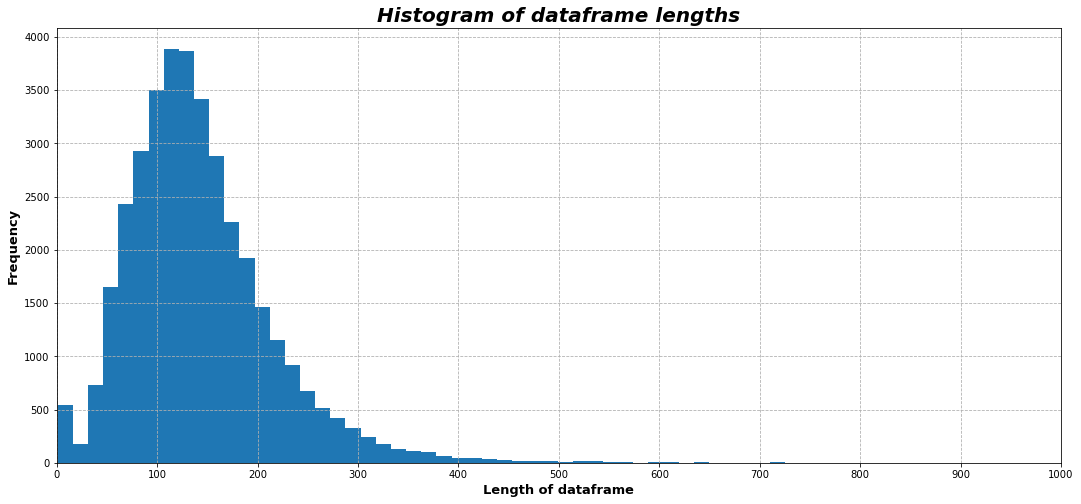

In [97]:
# get list of shape[0] from results
results_shape = [r.shape[0] for r in results]
plt.figure()
plt.hist(results_shape, bins=100)
plt.xlabel('Length of dataframe')
plt.ylabel('Frequency')
plt.title('Histogram of dataframe lengths', style='italic')
plt.xlim(0, 1000)
# make x-ticks every 100
plt.xticks(np.arange(0, 1100, 100))
plt.grid(linestyle='--')
plt.show()



Noting that 1 row of data is 5 seconds we can determine that the bulk of our replays are of between 9 and 11 minutes in length.

In [98]:
# we aggregated by 112 frames (5 second), so to find the replays that we can use
# we need to specify a range of acceptable lengths, 5 min to 45 min
min_frames = 5*60*22.4/112
max_frames = 45*60*22.4/112

# get the count of results that have a length between min_frames and max_frames
results_count = 0
for result in results:
    if min_frames <= result.shape[0] <= max_frames:
        results_count += 1

print(f'{results_count} results have acceptable length')

33908 results have acceptable length



---

---

## Conclusion <a name="section-3"></a>

In this Notebook we have:
* Created two sets of clean Metadata, one for the SpawningTool dataset, and one for Blizzard. These are stored in `csv` files at `data/spawningtool_replays.csv` and `data/blizzard_replays.csv` respectively.
* Created 36,812 cleaned event dataframes with data aggregated to 5 second intervals (112 frames). These are stored in pickle files with the `.zip` extension in `data/clean_events`

The following Notebook, Notebook 2, will investigate the Metadata:
* Exploratory data analysis will be performed to understand the distribution of players and statistics in both datasets.
* Modeling of the Metadata to attempt predicting the game outcome at the outset of the game will be attempted. Blizzard data will be used to train, validate and test the model. And SpawningTool data will be used as a supplementary test.